# Age of infection model

In [1]:
from pathlib import Path
from pprint import pprint
import yaml

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [18, 6]
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'

path_data = Path("../data/")

In [2]:
matplotlib.rcParams['lines.linestyle'] = ''
matplotlib.rcParams['lines.marker'] = '*'


In [3]:
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['font.size'] = 14

In [4]:
is_title_off = True

In [5]:
from pandas_utils import text_interval_index_to_interval_index, closed_ranges_to_interval_index, rougher_binning


## Next steps:
* create data to run on
    - diff tsvikas data
    - fetch manually
* present data on graph
* run fit once
    - Guy Ishay, mandelker
    - read briefly on sp.optimize.curve_fit
    - lm_fit
* load and display current predictions of gartner
* try to reproduce their model. even not precisely.
* remember I can also use the R(t)


## running predictions using their params and compare

## then adaptations:
* 1
* 2
* Population is devided to 2 sub groups: one standard, protected. The protected is affected but not affecting.
    - The time propagation of the standard (susceptible, exposed) is as usual
    - The protected has a narrow bridge to the world: either an old person with a caretaker that hardly goes out, or with a caretaker that hardly goes in. In any case, the chances of the protected person becoming infected depends on the chances of his caretaker becoming infected * becoming_infected_coefficient that represents the narrow bridge (low interaction with good hygene)

### next steps
1. initial conditions: 1-10 march, shift back, factor for hidden: OK
1. use R by sigmoid function from correct date : OK, possible
1. run prediction again : works. I leave aside the comparison. their predictions for april are without the sigmoid anyway
1. plugin: protecting the elders
    1. write model OK
    1. which parameters? make sure I can get them:
        1. CFR by age group: from my team - waiting for
        1. interactions ratio. Estimate form team - waiting for
    1. write design: OK
    1. code : OK
    1. clean the code a bit + make it run. time for  new notebook
1. fitting only to hospitalization === moderate severe data

## Next steps:
* finish transitions of other groups
* recovering
* finish and arrange

### zoom out
* stop for a second to think of data structures, what we have:
    * spread of the disease
        * becoming exposed, becoming infective
        * model of interactions
            * simplification: groups of people. equivalence classes.
            * interactions of an individual with all people. Who do you meet? what kind of interaction? does he infect you?
                * interactions class
                        * usual
                        * differential social distancing
            * probability of infection upon interaction
                * medical condition of infector (for example pre-symptomatic VS non-symptomatic
                * age of infection
    * development of medical condition
        * depends on person type
            * age
            * background medical state

## next steps:
* table that summarizes infected, sick, respirated, dead
* different scenarios

## little bit of data and initial conditions

In [6]:
confirmed = pd.read_csv(Path('./../../israel-covid19-data.git/IsraelCOVID19.csv'), index_col=0, header=0, names=['cases_tot', 'cases_new', 'moderate_tot', 'severe_tot', 'dead_tot', 'recovered'], parse_dates=True, dayfirst=True)
confirmed.head()

cases_tot  cases_new  moderate_tot  severe_tot  dead_tot  \
2020-02-21          2          2           NaN         NaN       NaN   
2020-02-22          2          0           NaN         NaN       NaN   
2020-02-23          2          0           NaN         NaN       NaN   
2020-02-24          2          0           NaN         NaN       NaN   
2020-02-25          2          0           NaN         NaN       NaN   

            recovered  
2020-02-21        NaN  
2020-02-22        NaN  
2020-02-23        NaN  
2020-02-24        NaN  
2020-02-25        NaN

In [7]:
#dates_initial_data = slice(pd.Timestamp('2020/03/09'), pd.Timestamp('2020/03/09') + infection_impulse_response.index[-1 - 1])
dates_initial_data = slice(pd.Timestamp('2020/03/01'), pd.Timestamp('2020/03/10'))
time_shift_to_infection_date = pd.Timedelta(10, unit='day')
exposed_to_symptomatic_ratio = 0.5
symptomatic_new_initial = confirmed.loc[dates_initial_data ].cases_new# / exposed_to_symptomatic_ratio
symptomatic_new_initial.index = symptomatic_new_initial.index - time_shift_to_infection_date
symptomatic_new_initial = symptomatic_new_initial.values
exposed_new_initial = symptomatic_new_initial / exposed_to_symptomatic_ratio
exposed_new_initial

array([ 4.,  0.,  6.,  2.,  8.,  4., 30.,  4., 40., 36.])

## time propagation: susceptible - exposed, how people affect each other:
* case 1: one population with feedback
* case 2: one population that is infective, the other is susceptible

### Generation time - given an individual is infected at day 0, how infective is he in the next days (normalized to sum 1)

In [8]:
def gamma_impulse_response(mean, std, x=None, normalization='sum1'):
    if x is None:
        x = np.arange(1, 1 + mean + 2 * std)
    gamma = sp.stats.gamma(mean ** 2 / std ** 2, 0, std ** 2 / mean)
    impulse_response = pd.Series(index=pd.TimedeltaIndex(x, unit='day'), data=gamma.pdf(x))
    if normalization == 'sum1':
        impulse_response = impulse_response / impulse_response.sum()
    else:
        raise ValueError('which normalization?')
    #print(impulse_response)
    return impulse_response

In [9]:
generation_time_mean = 4
generation_time_std = 2
infection_impulse_response = gamma_impulse_response(generation_time_mean, generation_time_std)#, np.arange(1, 1 + generation_time_mean + 2 * generation_time_std))

In [10]:
fig, ax = plt.subplots() 
infection_impulse_response.plot(ax=ax)

### time propagation

In [11]:
import warnings

In [12]:
def susceptible_exposed_time_propagation(N_steps, susceptible_0, exposed_new_initial, contact_population_size, contact_population_infector_new, infection_impulse_response, R, interactions_ratio, infection_probability_ratio=1, linear_approximation_being_infected_probability=False):
    """
    For the group you consider. Please understand:
    what is the size of the susceptible population
    
    What is the contacts pool of this group?
    what is the pool size?
    How many infected are in this group in any given day?
    What is the number of interactions ratio compared to normal interactions by normal person in normal day
    
    Normal people contact normal people (most of the population), normal interactions
    people that lower their interaction (such as 60 years old people, or caretakers): interact normal people, with fraction of interactions
    elders that live on their own: contact normal people, very low fraction of interactions
    elders that live with a caretaker: contact the pool of caretakers, with moderate fraction of interactions: few times a day cooking ETC
    """
    probability_being_infected_warning_threshold = 0.1
    
    T = len(infection_impulse_response)
    susceptible = np.zeros(N_steps)
    exposed_new = np.zeros(N_steps)
    
    if exposed_new_initial is None:
        exposed_new_initial = np.zeros(T)
    exposed_new[:len(exposed_new_initial)] = exposed_new_initial
    #print(exposed_new)
    susceptible[0] = susceptible_0

    if type(contact_population_infector_new) is str and contact_population_infector_new == 'SUSCEPTIBLE_INFECTORS_SAME_POPULATION':
        contact_population_infector_new = exposed_new
        assert contact_population_infector_new is exposed_new
        #print(contact_population_infector_new)
    
    # reminder: these equations assume susceptible[i]: number of susceptible people at beginning of day i
    for i in range(1, len(exposed_new_initial)):
        susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]
    
    for i in range(len(exposed_new_initial), N_steps):
        susceptible[i] = susceptible[i - 1] - exposed_new[i - 1]
        # using linear approx given an argument of exponent << 1
        R_effective = R * interactions_ratio * infection_probability_ratio
        probability_being_infected_est = (contact_population_infector_new[i - T : i] / contact_population_size).dot(R_effective * infection_impulse_response[::-1])
        if linear_approximation_being_infected_probability:
            probability_being_infected = probability_being_infected_est
            if probability_being_infected > probability_being_infected_warning_threshold:
                warnings.warn(f"probability_being_infected: {probability_being_infected}, day: {i}")
        else:
            probability_being_infected = 1 - np.exp((-1) * probability_being_infected_est)
        
        exposed_new[i] = susceptible[i] * probability_being_infected
        #print(exposed_new[i])
        #R * interactions_ratio / population * infector_new[i - T : i].dot(infection_impulse_response[::-1]))
    
    #assert exposed_new is contact_population_infector_new
    #exposed_new = pd.Series(index=t, data=exposed_new)
    #susceptible = pd.Series(index=t, data=susceptible)
    if exposed_new[-30] > 1:
        warnings.warn(f'susceptible exposed time propagation did not converge R{R} interactions_ratio{interactions_ratio} N_steps{N_steps} exposed_new step -30 {exposed_new[-30]} exposed_new step -1 {exposed_new[-1]}')
    return susceptible, exposed_new

#_, exposed_new_try =  susceptible_exposed_time_propagation(N_steps=100, susceptible_0=population, exposed_new_initial=exposed_new_initial / transitions[SourceDestination(Status.exposed, Status.symptomatic)].p, contact_population_size=population, contact_population_infector_new="SUSCEPTIBLE_INFECTORS_SAME_POPULATION", infection_impulse_response=infection_impulse_response, R=2, interactions_ratio=1)


### example normal group with feedback

In [13]:
population = 9e6
R = 2
susceptible, exposed_new =  susceptible_exposed_time_propagation(N_steps=100, susceptible_0=population, exposed_new_initial=exposed_new_initial, contact_population_size=population, contact_population_infector_new="SUSCEPTIBLE_INFECTORS_SAME_POPULATION", infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=1)


/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: susceptible exposed time propagation did not converge R2 interactions_ratio1 N_steps100 exposed_new step -30 233041.35682644096 exposed_new step -1 672.093154438808


In [14]:
population = 9e6
R = 2
susceptible, exposed_new =  susceptible_exposed_time_propagation(N_steps=200, susceptible_0=population, exposed_new_initial=exposed_new_initial, contact_population_size=population, contact_population_infector_new="SUSCEPTIBLE_INFECTORS_SAME_POPULATION", infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=1,
                            linear_approximation_being_infected_probability=False)


In [15]:
np.round(pd.Series(exposed_new).sum(), -4)

7170000.0

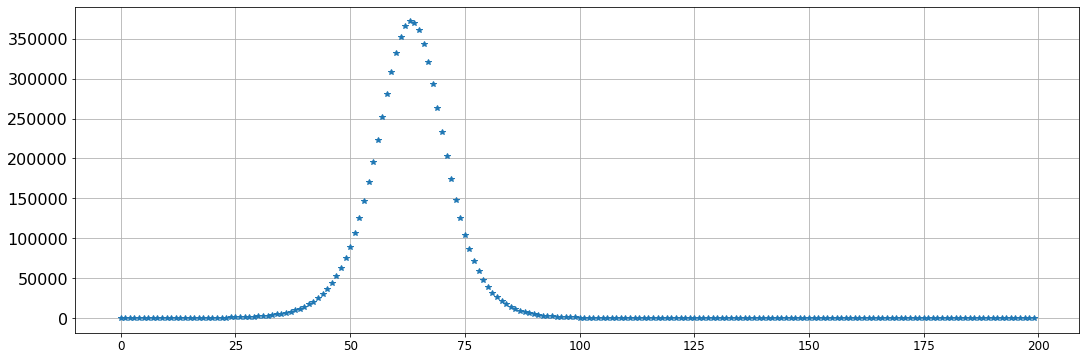

In [16]:
pd.Series(exposed_new).plot()

### example passive group that can be only infected

In [590]:
low_population = 5e5
low_interaction_ratio = 0.2
low_susceptible, low_exposed_new = susceptible_exposed_time_propagation(N_steps=200, susceptible_0=low_population, exposed_new_initial=None, contact_population_size=population, contact_population_infector_new=exposed_new, infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=low_interaction_ratio)


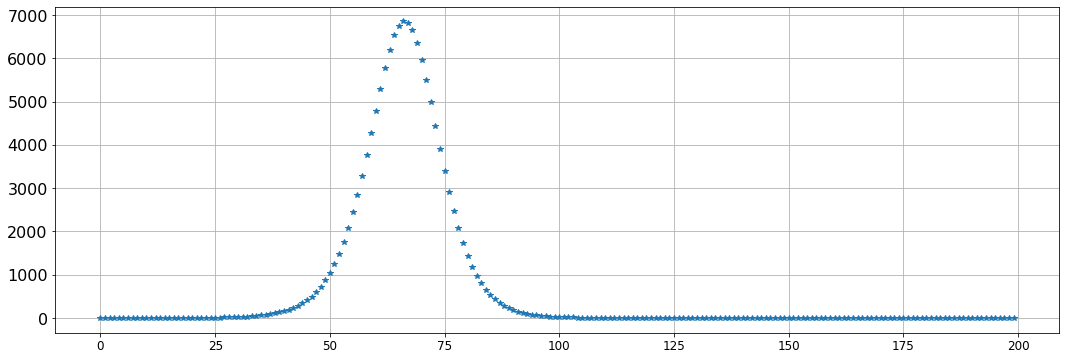

In [591]:
pd.Series(low_exposed_new).plot()

### example with infection_probability_ratio

In [17]:
low_population = 5e5
low_interaction_ratio = 0.2
infection_probability_ratio = 0.5
low_susceptible, low_exposed_new = susceptible_exposed_time_propagation(N_steps=200, susceptible_0=low_population, exposed_new_initial=None, contact_population_size=population, contact_population_infector_new=exposed_new, infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=low_interaction_ratio, infection_probability_ratio=infection_probability_ratio)


In [18]:
pd.Series(low_exposed_new).plot()

### TODO: should incorporate: case where R is time dependent

In [15]:
def sigmoid(t, K, A, Q, B):
    return K + A / (1 + Q * np.exp(B * t-10))

def some_code_relevant_to_R_sigmoid():
    if not sigmoid_params is None and not R is None:
        raise ValueError('given both R and sigmoid params')
    if not sigmoid_params is None and R is None:
        R_t = sigmoid(t, **sigmoid_params)
    else:
        R_t = np.ones_like(t) * R

## Transitions: how people's medical status develops over time

### the possible states

In [19]:
from collections import OrderedDict


from enum import IntEnum
class Status(IntEnum):
    susceptible = 1
    exposed = 2
    symptomatic = 3
    moderate_severe = 4
    respirated = 5
    dead = 6
    recover = 7

### parameters required for transition

In [20]:
from collections import namedtuple
SourceDestination = namedtuple('SourceDestination', 'source destination')
TransitionAttributes = namedtuple('TransitionAttribues', 'p impulse_response') # future possible design: P as a vector of probabilities per age group
TransitionAttributes.__new__.__defaults__ = (None, None)

###  time delays between stages: impulse responses

In [21]:
def delayed_uniform_impulse_response(t1, t2, x=None, normalization='sum1'):
    if x is None:
        x = np.arange(1, t2 + 1)
    uniform = sp.stats.uniform(loc=t1+1, scale=(t2-t1))
    impulse_response = pd.Series(index=pd.TimedeltaIndex(x, unit='day'), data=uniform.pdf(x))
    if normalization == 'sum1':
        impulse_response = impulse_response / impulse_response.sum()
    else:
        raise ValueError('which normalization?')
    #print(impulse_response)
    return impulse_response
    

### transitions to harder medical stages: conditional probabilities and delays

In [22]:
transitions_template = OrderedDict({
    SourceDestination(Status.exposed, Status.symptomatic) : TransitionAttributes(p=None, impulse_response=gamma_impulse_response(5.5, 2.3)),
    SourceDestination(Status.symptomatic, Status.moderate_severe) : TransitionAttributes(p=None, impulse_response=gamma_impulse_response(8.4, 4.9)), #0.066
    SourceDestination(Status.symptomatic, Status.respirated): TransitionAttributes(p=None, impulse_response=gamma_impulse_response(9.9, 5.6)), #0.023
    SourceDestination(Status.symptomatic, Status.dead): TransitionAttributes(p=None, impulse_response=gamma_impulse_response(10.9, 6)), #0.0092
})


### recovering: transitions to better medical stages: conditional probabilities and delays

In [23]:
transitions_template.update({
    #SourceDestination(Status.exposed, Status.recover) : TransitionAttributes(p=None, impulse_response=delayed_uniform_impulse_response(len(infection_impulse_response) + 1, len(infection_impulse_response) + 3)), #basically when you become non infective you recover from exposed
    SourceDestination(Status.symptomatic, Status.recover) : TransitionAttributes(p=None, impulse_response=delayed_uniform_impulse_response(7, 14)), #1-0.066
    SourceDestination(Status.moderate_severe, Status.recover) : TransitionAttributes(p=None, impulse_response=delayed_uniform_impulse_response(14, 28)), #(0.066-0.023)/0.066
    SourceDestination(Status.respirated, Status.recover) : TransitionAttributes(p=None, impulse_response=delayed_uniform_impulse_response(7, 14)), #(0.023 - 0.0092)/0.023
})

#### compute transitions probability source, dest, with recoveries

In [24]:
def compute_transitions_probability(transitions_template, relative_rates):    
    transitions_out = transitions_template.copy()
    for source_dest, attr in transitions_out.items():
        #print(attr)
        source, destination = source_dest.source, source_dest.destination
        relative_rates_temp = relative_rates#[GroupInteractions.normal]
        #print(relative_rates_temp[source])
        if source in relative_rates_temp.index and destination in relative_rates_temp.index:
            transitions_out[source_dest] = attr._replace(p=relative_rates_temp[destination] / relative_rates_temp[source])

    for source in list(Status)[Status.symptomatic  - 1: Status.dead - 1]:
        relative_rates_temp = relative_rates#[GroupInteractions.normal]
        #print(source)
        p = 1 - relative_rates_temp[Status(source + 1)] / relative_rates_temp[source]
        transitions_out[SourceDestination(source, Status.recover)] = transitions_out[SourceDestination(source, Status.recover)]._replace(p=p)
    # using the relative IFR, IHR, IRR rates, and absolute IFR, get absolute IHR, IRR and as bonus IHR, IRR by age group
    return transitions_out

#transitions_normal = compute_transitions_probability(transitions_template=transitions, relative_rates=relative_rates_group[GroupInteractions.normal.value])
#transitions_normal
#normal_relative_rates = get_relative_rates_normalized_on_ages(age_pyramid, top_age_group=pd.Interval(60, 69, 'both'), exposed_to_symptomatic_ratio, rates)

In [25]:
relative_rates_template = pd.Series(index=[Status.exposed, Status.symptomatic, Status.moderate_severe, Status.respirated, Status.dead])
relative_rates_official = pd.Series(index=[Status.exposed, Status.symptomatic, Status.moderate_severe, Status.respirated, Status.dead], data=[None, 1, 0.066, 0.0231, 0.0092])

relative_rates_official_with_exposed = relative_rates_official.copy()
relative_rates_official_with_exposed[Status.exposed] = relative_rates_official_with_exposed[Status.symptomatic] / exposed_to_symptomatic_ratio
transitions = compute_transitions_probability(transitions_template, relative_rates_official_with_exposed)

/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [26]:
[tp.p for k, tp in transitions.items()]

[0.5, 0.066, 0.0231, 0.0092, 0.9339999999999999, 0.65, 0.6017316017316017]

In [27]:
[tp.p for k, tp in transitions.items()]

[0.5, 0.066, 0.0231, 0.0092, 0.9339999999999999, 0.65, 0.6017316017316017]

### some plots of impulse responses

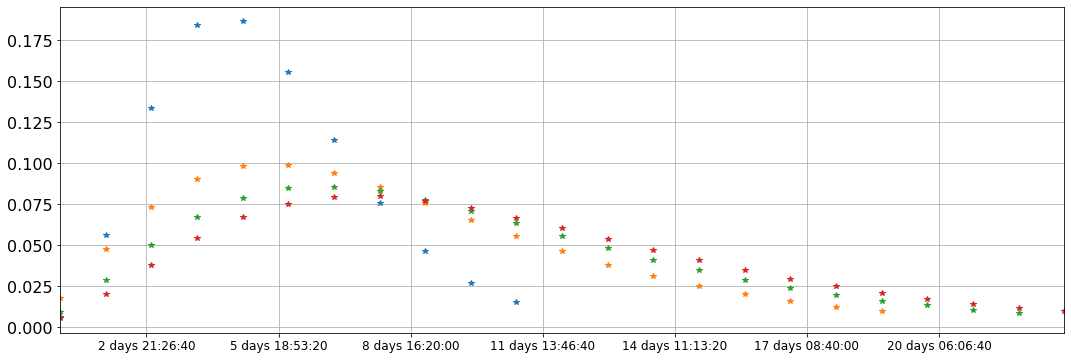

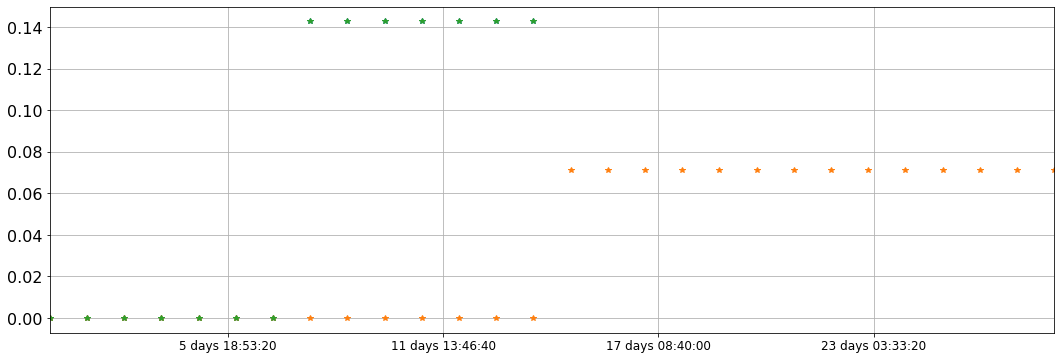

In [28]:
fig, ax = plt.subplots() 

for source_dest, transition_attributes in transitions.items():
    if not source_dest.destination is Status.recover:
        transition_attributes.impulse_response.plot(ax=ax)
#pd.Series(index=x, data=gamma.pdf(x)).plot()
fig, ax = plt.subplots() 
for source_dest, transition_attributes in transitions.items():
    if source_dest.destination is Status.recover:
        transition_attributes.impulse_response.plot(ax=ax)


### utils: convolutions with indices

In [29]:
def convolution_with_indices(cause, ir, mode='full'):
    if mode == 'valid':
        pad = np.array([np.nan, ] * len(ir))
        response = np.concatenate([pad, np.convolve(cause, ir.values, mode='valid')[:-1]])
    elif mode == 'full':
        response = np.concatenate([np.array([0]), np.convolve(cause, ir.values, mode='full')[:len(cause) - 1]])
    
    return response

def example_convolution_with_indices_valid():
    A = np.arange(5)
    A_ir = pd.Series([2, 1])
    expected = np.array([np.nan, np.nan, 2, 5, 8])
    print(A)
    print(convolution_with_indices(A, A_ir, 'valid'))
    print(expected)


def example_convolution_with_indices_full():
    A = np.arange(5)
    A_ir = pd.Series([2, 1])
    expected = np.array([0, 0, 2, 5, 8])
    print(A)
    print(convolution_with_indices(A, A_ir, 'full'))
    print(expected)

example_convolution_with_indices_valid()
example_convolution_with_indices_full()

[0 1 2 3 4]
[nan nan  2.  5.  8.]
[nan nan  2.  5.  8.]
[0 1 2 3 4]
[0 0 2 5 8]
[0 0 2 5 8]


### transitions

In [30]:
def time_propagations_transitions(susceptible, exposed_new, transitions):
    warnings.warn('bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected')
    # trying to fix: can take exposed-recover into account in transitions, but this depends on the exposed-symptomatic ratio, that is a parameter that can be changed for each run
    # so the fix required adapting transitions before each run from the rates, which I didn't do so far
    warnings.warn('bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong')
    t = np.arange(len(susceptible))
    t = pd.TimedeltaIndex(data=t, unit='day', name='date')
    
    multi_index = pd.MultiIndex.from_tuples((('exposed', 'new'),), names=['status', 'attr'])
    dynamics = pd.DataFrame(index=t, data=exposed_new.T, columns=multi_index)

    # derive the transitions between states
    transitions_daily = pd.DataFrame(index=t, data=exposed_new.T, columns=pd.MultiIndex.from_tuples((('susceptible', 'exposed'),), names=['source', 'destination']))
    
    for source_dest, params in transitions.items():
        assert source_dest.source < source_dest.destination
        source, dest = source_dest.source.name, source_dest.destination.name
        #print(source, dest)
        transitions_daily[source, dest] = params.p * convolution_with_indices(dynamics[source, 'new'], params.impulse_response)
        if (dest, 'new') in dynamics.columns:
            dynamics[dest, 'new'] += transitions_daily[source, dest]
        else:
            dynamics[dest, 'new'] = transitions_daily[source, dest].copy()
    
    # checksum
    if True:
        for s in Status:
            if (s.name, 'new') in dynamics.columns:
                assert np.allclose(dynamics[s.name, 'new'], transitions_daily.xs(s.name, level='destination', axis=1).sum(axis=1))
    # net change
    if True:
        for s in Status:
            if (s.name, 'new') in dynamics.columns and s.name in transitions_daily.columns.to_frame(index=False).source.values:
                dynamics[s.name, 'net_delta'] = dynamics[s.name, 'new'] - transitions_daily.xs(s.name, level='source', axis=1).sum(axis=1)
    
    return dynamics, transitions_daily

### example:

In [31]:
dynamics, transitions_daily = time_propagations_transitions(susceptible, exposed_new, transitions)

/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected
  
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong
  """


In [32]:
dynamics.dead.new.sum()

32988.11072512274

## time propagation and transitions

In [33]:
#exposed_new_initial, population, susceptible_0, infection_impulse_response, R, N_steps, transitions
#(exposed_new_initial, R, transitions, population, N)
def epidemic_dynamics(exposed_new_initial, population, susceptible_0, infection_impulse_response, R, N_steps, transitions, interactions_ratio=1, infection_probability_ratio=1, linear_approximation_being_infected_probability=False):
    sigmoid_params=None
    #print(N)
    
    #empiric_approx_factor_hospitalized_to_moderate_severe = 1
    
    #group = 'normal'
    susceptible, exposed_new = susceptible_exposed_time_propagation(N_steps=N_steps, susceptible_0=susceptible_0, exposed_new_initial=exposed_new_initial, contact_population_size=population, contact_population_infector_new="SUSCEPTIBLE_INFECTORS_SAME_POPULATION", infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=interactions_ratio, infection_probability_ratio=infection_probability_ratio, linear_approximation_being_infected_probability=linear_approximation_being_infected_probability)
    dynamics, transitions_daily = time_propagations_transitions(susceptible, exposed_new, transitions)
    #dynamics = pd.concat([dynamics], keys=['normal'], names=['group'], axis=1)
    #transitions_daily = pd.concat([transitions_daily], keys=['normal'], names=['group'], axis=1)
    
    # already supports this functionality outside this function. it's just hard for me to delete this code
    if False:
        print("TODO: adapt epidemic_dynamics to easily support different passive groups, And also return their dynamics in the results. probably with additional column index level")
        # now population that keeps low interactions. such as
        # TODO: 60-70 years old, and caretakers
        group = 'low'
        low_population = 5e5
        low_interaction_ratio = 0.2
        low_susceptible, low_exposed_new = susceptible_exposed_time_propagation(N_steps=N, susceptible_0=low_population, exposed_new_initial=None, contact_population_size=population, contact_population_infector_new=exposed_new, infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=low_interaction_ratio)
        dynamics_dict[group], transitions_daily_dict[group] = time_propagations_transitions(low_susceptible, low_exposed_new, transitions)


        # now population that gets deliveries twice a week
        # TODO: all people above age 70 that are not supported
        group = 'supplies'
        supplies_population = 2e5
        supplies_interaction_ratio = 0.05
        supplies_susceptible, supplies_exposed_new = susceptible_exposed_time_propagation(N_steps=N, susceptible_0=supplies_population, exposed_new_initial=None, contact_population_size=population, contact_population_infector_new=exposed_new, infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=supplies_interaction_ratio)
        dynamics_dict[group], transitions_daily_dict[group] = time_propagations_transitions(supplies_susceptible, supplies_exposed_new, transitions)

        # now poulation that is supported: lives with a caretaker
        # TODO: all elders that have severe mobility issues
        group = 'supported'
        supported_population = 2e5
        supported_interaction_ratio = 0.5
        supported_susceptible, supported_exposed_new = susceptible_exposed_time_propagation(N_steps=N, susceptible_0=supported_population, exposed_new_initial=None, contact_population_size=low_population, contact_population_infector_new=low_exposed_new, infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=supported_interaction_ratio)
        dynamics_dict[group], transitions_daily_dict[group] = time_propagations_transitions(supported_susceptible, supported_exposed_new, transitions)

    # = = = = #
    
    

    return dynamics, transitions_daily


    dynamics['low_exposed', 'new'] = low_exposed_new
    dynamics['supllies_exposed', 'new'] = supplies_exposed_new
    dynamics['supported_exposed', 'new'] = supported_exposed_new


In [34]:
prediction_2, transitions_daily_2 = epidemic_dynamics(exposed_new_initial=exposed_new_initial,
                              R=1.35,
                              infection_impulse_response=infection_impulse_response,
                              transitions=transitions,
                              population=population,
                              susceptible_0 = population,
                              N_steps=320)


/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected
  
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong
  """


In [35]:
prediction_2.exposed.iloc[-30:]

attr           new  net_delta
date                         
290 days  0.308324   0.061394
291 days  0.283328   0.056416
292 days  0.260357   0.051843
293 days  0.239249   0.047640
294 days  0.219852   0.043777
295 days  0.202028   0.040228
296 days  0.185649   0.036967
297 days  0.170598   0.033970
298 days  0.156767   0.031216
299 days  0.144057   0.028685
300 days  0.132378   0.026359
301 days  0.121646   0.024222
302 days  0.111783   0.022258
303 days  0.102721   0.020454
304 days  0.094393   0.018796
305 days  0.086740   0.017272
306 days  0.079708   0.015871
307 days  0.073246   0.014585
308 days  0.067307   0.013402
309 days  0.061850   0.012316
310 days  0.056836   0.011317
311 days  0.052228   0.010400
312 days  0.047994   0.009557
313 days  0.044103   0.008782
314 days  0.040527   0.008070
315 days  0.037242   0.007416
316 days  0.034222   0.006814
317 days  0.031448   0.006262
318 days  0.028898   0.005754
319 days  0.026555   0.005288

In [36]:
prediction_2.columns

MultiIndex([(        'exposed',       'new'),
            (    'symptomatic',       'new'),
            ('moderate_severe',       'new'),
            (     'respirated',       'new'),
            (           'dead',       'new'),
            (        'recover',       'new'),
            (        'exposed', 'net_delta'),
            (    'symptomatic', 'net_delta'),
            ('moderate_severe', 'net_delta'),
            (     'respirated', 'net_delta')],
           names=['status', 'attr'])

In [37]:
prediction_2.dead.new.sum()

19429.453337440387


pd.concat([prediction_2], keys=['Foo'], names=['group'], axis=1)

In [38]:
prediction_2.exposed.new.plot(linestyle='', marker='*')

### 

In [39]:
summary_table = prediction_2.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())
summary_table.astype(int)

status
exposed            4223795
symptomatic        2111897
moderate_severe     139385
respirated           48784
dead                 19429
recover            2092467
dtype: int64

### wrap it up: initialize epidemic dynamics and run

In [40]:
def initialize_epidemic_dynamics(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates, interactions_ratio=1, infection_probability_ratio=1):
    exposed_new_initial = symptomatic_new_initial / exposed_to_symptomatic_ratio
    susceptible_0 = population * susceptible_ratio
    
    relative_rates = relative_rates.copy()
    relative_rates[Status.exposed] = relative_rates[Status.symptomatic] / exposed_to_symptomatic_ratio
    transitions = compute_transitions_probability(transitions_template, relative_rates)
    
    return exposed_new_initial, population, susceptible_0, infection_impulse_response, R, N_steps, transitions, interactions_ratio, infection_probability_ratio

In [41]:
exposed_to_symptomatic_ratio = exposed_to_symptomatic_ratio
R = 1.35
N_steps = 350
susceptible_ratio = 1
population = 9e6
relative_rates = relative_rates_official
infection_impulse_response = infection_impulse_response
dynamics, transitions_daily = epidemic_dynamics(*initialize_epidemic_dynamics(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates))
summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())#collect_summary_table
#stack_all_summary_tables_by_PD_R

/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected
  
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong
  """


### understanding the bug that causes net_detla.cumsum() at t~infinite of symptomatic to be negative, and of moderate_severe, respirated to be positive
* the bug probably stems from glitch regarding whether the groups of symptomatic, moderate_severe etc are inclusive or exclusive
* the amount of peope that are "overdrawn" from symptomatic seems eaquel to the surpluss in moderate_severe + respirated
* the surpluss in respirated is seems equal to all dead, the surpluss in moderate severe seems like all respirated
* in the transitions, people progress from symptomatic to moderate_severe, respirated, dead, in counting how many leave, we count too many times

In [493]:
transitions_daily.xs('moderate_severe', level='source', axis=1)#.sum(axis=1)

destination   recover
date                 
0 days       0.000000
1 days       0.000000
2 days       0.000000
3 days       0.000000
4 days       0.000000
...               ...
345 days     0.001377
346 days     0.001265
347 days     0.001163
348 days     0.001069
349 days     0.000982

[350 rows x 1 columns]

In [491]:
summary_table / summary_table.symptomatic

status
exposed            2.0000
symptomatic        1.0000
moderate_severe    0.0660
respirated         0.0231
dead               0.0092
recover            0.9908
dtype: float64

In [605]:
summary_table.astype(int)

status
exposed            4223795
symptomatic        2111897
moderate_severe     139385
respirated           48784
dead                 19429
recover            2092468
dtype: int64

In [486]:
relative_rates_official

2       NaN
3    1.0000
4    0.0660
5    0.0231
6    0.0092
dtype: float64

In [471]:
pprint(list(transitions.keys()))

[SourceDestination(source=<Status.exposed: 2>, destination=<Status.symptomatic: 3>),
 SourceDestination(source=<Status.symptomatic: 3>, destination=<Status.moderate_severe: 4>),
 SourceDestination(source=<Status.symptomatic: 3>, destination=<Status.respirated: 5>),
 SourceDestination(source=<Status.symptomatic: 3>, destination=<Status.dead: 6>),
 SourceDestination(source=<Status.symptomatic: 3>, destination=<Status.recover: 7>),
 SourceDestination(source=<Status.moderate_severe: 4>, destination=<Status.recover: 7>),
 SourceDestination(source=<Status.respirated: 5>, destination=<Status.recover: 7>)]


In [472]:
transitions_daily.columns

MultiIndex([(    'susceptible',         'exposed'),
            (        'exposed',     'symptomatic'),
            (    'symptomatic', 'moderate_severe'),
            (    'symptomatic',      'respirated'),
            (    'symptomatic',            'dead'),
            (    'symptomatic',         'recover'),
            ('moderate_severe',         'recover'),
            (     'respirated',         'recover')],
           names=['source', 'destination'])

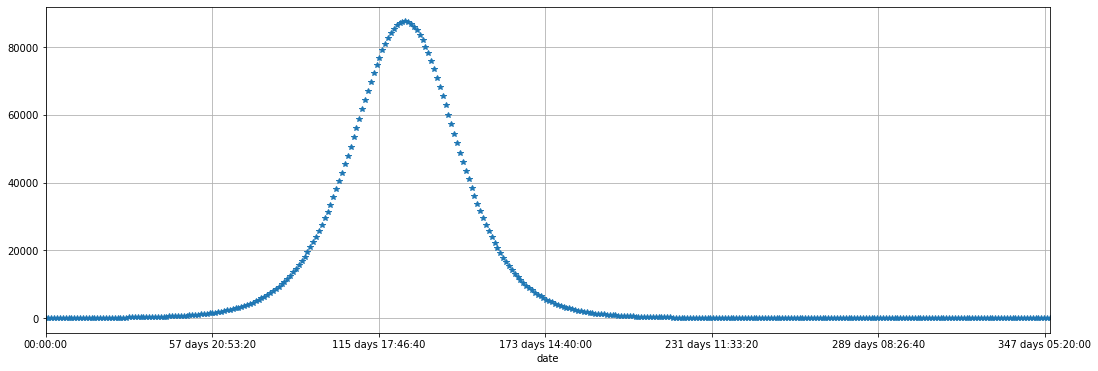

In [473]:
dynamics.exposed.new.plot()

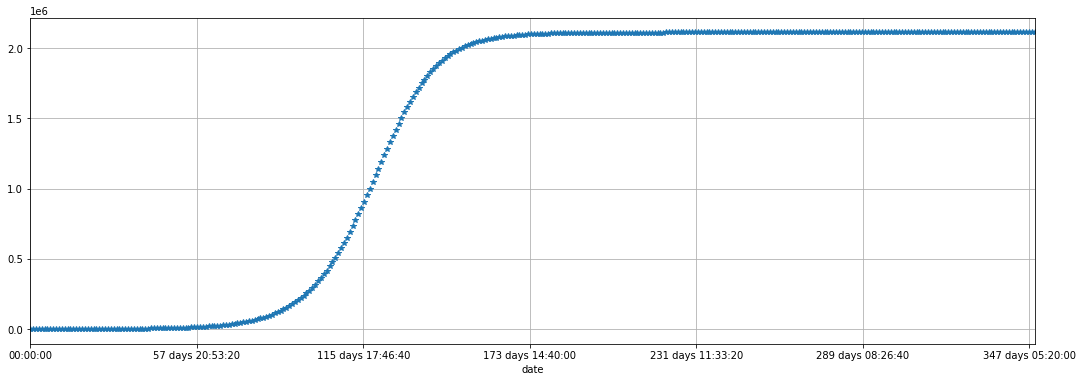

In [474]:
dynamics.exposed.net_delta.cumsum().plot()

In [454]:
transitions_daily

source      susceptible     exposed     symptomatic                           \
destination     exposed symptomatic moderate_severe respirated          dead   
date                                                                           
0 days         4.000000    0.000000        0.000000   0.000000  0.000000e+00   
1 days         0.000000    0.012008        0.000000   0.000000  0.000000e+00   
2 days         6.000000    0.111763        0.000014   0.000003  6.129240e-07   
3 days         2.000000    0.285695        0.000167   0.000032  7.935002e-06   
4 days         8.000000    0.541429        0.000740   0.000149  3.952816e-05   
...                 ...         ...             ...        ...           ...   
345 days       0.002947    0.002361        0.000325   0.000131  5.664270e-05   
346 days       0.002709    0.002169        0.000298   0.000120  5.205048e-05   
347 days       0.002489    0.001993        0.000274   0.000111  4.783056e-05   
348 days       0.002287    0.001832        0.000252   0.000102  4.395277e-05   
349 days       0.002102    0.001683        0.000232   0.000093  4.038936e-05   

source                moderate_severe respirated  
destination   recover         recover    recover  
date                                              
0 days       0.000000        0.000000   0.000000  
1 days       0.000000        0.000000   0.000000  
2 days       0.000000        0.000000   0.000000  
3 days       0.000000        0.000000   0.000000  
4 days       0.000000        0.000000   0.000000  
...               ...             ...        ...  
345 days     0.005668        0.001377   0.000203  
346 days     0.005209        0.001265   0.000186  
347 days     0.004787        0.001163   0.000171  
348 days     0.004399        0.001069   0.000157  
349 days     0.004042        0.000982   0.000145  

[350 rows x 8 columns]

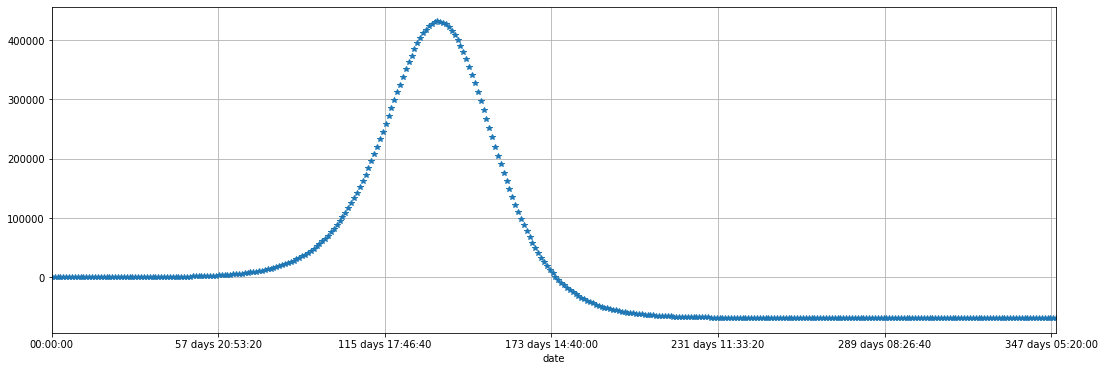

In [488]:
dynamics.symptomatic.net_delta.cumsum().plot()

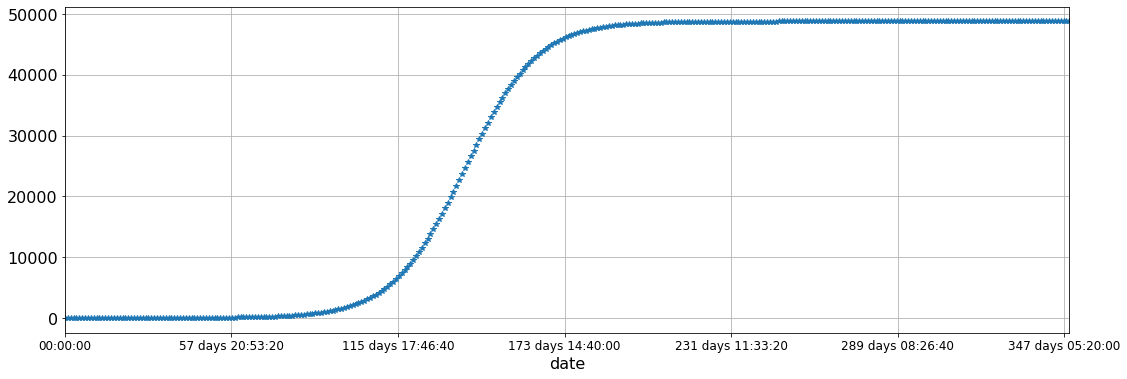

In [606]:
transitions_daily.symptomatic.respirated.cumsum().plot()

In [607]:
transitions_daily.respirated.recover.cumsum().plot()

### taking susceptible ratio into account

In [39]:
def estimate_susceptible_ratio(ratio_confirmed_cases_to_population_at_peak, exposed_to_symptomatic_ratio, robustness_factor=3):
    expected_total_cases_to_cases_at_peak = 2
    susceptible_ratio = ratio_confirmed_cases_to_population_at_peak / exposed_to_symptomatic_ratio * expected_total_cases_to_cases_at_peak * robustness_factor
    return susceptible_ratio
    
max_confirmed_cases_in_peak_countries = 0.6e-2
susceptible_ratio_0 = estimate_susceptible_ratio(max_confirmed_cases_in_peak_countries, exposed_to_symptomatic_ratio)
susceptible_ratio_0

0.07200000000000001

## multiple passive groups

In [42]:
from enum import Enum

class GroupInteractions(Enum):
    normal = 'normal'
    low = 'low'
    supplies = 'supplies'
    support = 'support'
    


In [43]:
GroupAttribues = namedtuple('GroupAttribues', 'size susceptible_0 exposed_new_initial infector infector_size, interactions_ratio transitions infection_probability_ratio')
GroupAttribues.__new__.__defaults__ = tuple([None, ] * 7 + [1,])

In [44]:
groups = OrderedDict({
    GroupInteractions.normal : GroupAttribues(size=8e6, susceptible_0=8e6, exposed_new_initial=exposed_new_initial, infector=GroupInteractions.normal, interactions_ratio=1, transitions=transitions),
    GroupInteractions.low : GroupAttribues(size=7e5, susceptible_0=7e5, exposed_new_initial=None, infector=GroupInteractions.normal, interactions_ratio=0.2, transitions=transitions),
    GroupInteractions.supplies : GroupAttribues(size=5e5, susceptible_0=5e5, exposed_new_initial=None, infector=GroupInteractions.normal, interactions_ratio=0.05, transitions=transitions),
    GroupInteractions.support : GroupAttribues(size=1.5e5, susceptible_0=1.5e5, exposed_new_initial=None, infector=GroupInteractions.low, interactions_ratio=0.5, transitions=transitions),

})

for group_interactions, attr in groups.items():
    groups[group_interactions] = attr._replace(infector_size=groups[attr.infector].size)
    
#groups

In [45]:
def epidemic_dynamics_with_passive_groups(N, R, infection_impulse_response, groups):
    dynamics_dict = OrderedDict({})
    transitions_daily_dict = OrderedDict({})

    group, attr = GroupInteractions.normal, groups[GroupInteractions.normal]
    susceptible, exposed_new = susceptible_exposed_time_propagation(N_steps=N, susceptible_0=attr.susceptible_0, exposed_new_initial=attr.exposed_new_initial, contact_population_size=attr.infector_size, contact_population_infector_new="SUSCEPTIBLE_INFECTORS_SAME_POPULATION", infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=attr.interactions_ratio, infection_probability_ratio=attr.infection_probability_ratio)
    dynamics_dict[group], transitions_daily_dict[group] = time_propagations_transitions(susceptible, exposed_new, attr.transitions)


    for group, attr in list(groups.items())[1:]: 
        susceptible, exposed_new = susceptible_exposed_time_propagation(N_steps=N, susceptible_0=attr.susceptible_0, exposed_new_initial=attr.exposed_new_initial, contact_population_size=attr.infector_size, contact_population_infector_new=dynamics_dict[attr.infector].exposed.new.values, infection_impulse_response=infection_impulse_response, R=R, interactions_ratio=attr.interactions_ratio, infection_probability_ratio=attr.infection_probability_ratio)
        dynamics_dict[group], transitions_daily_dict[group] = time_propagations_transitions(susceptible, exposed_new, attr.transitions)

    dynamics = pd.concat(dynamics_dict.values(), keys=dynamics_dict.keys(), names=['group'], axis=1)
    transitions_daily = pd.concat(transitions_daily_dict.values(), keys=transitions_daily_dict.keys(), names=['group'], axis=1)
    
    return dynamics, transitions_daily

In [46]:
    
dynamics, transitions_daily = epidemic_dynamics_with_passive_groups(N=350, R=1.35, infection_impulse_response=infection_impulse_response, groups=groups)

/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected
  
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong
  """


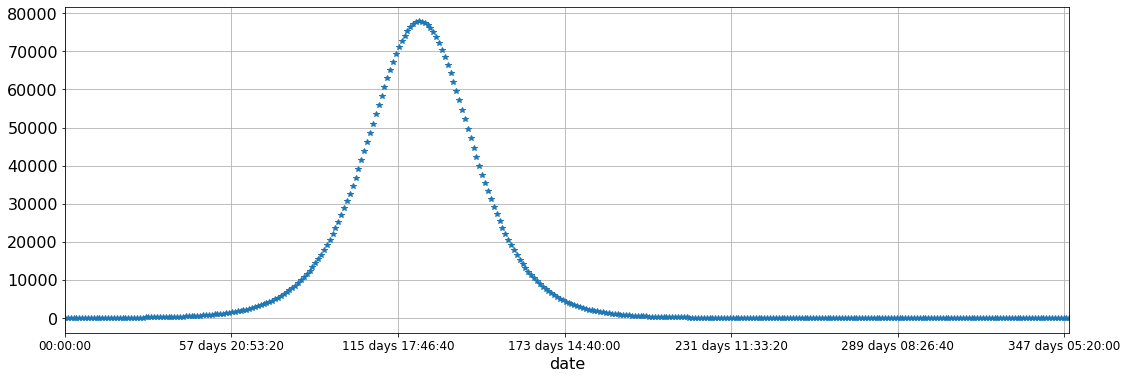

In [47]:
dynamics[GroupInteractions.normal].exposed.new.plot()

In [48]:
dynamics.xs(('dead', 'new'), level=('status', 'attr'), axis=1).sum().sum()

17778.91525564589

### IFR: taking age to account, taking group to account

#### normalizaition of hospitalized, respirated, dead

In [49]:
## This part is not implemented yet. It involves computing a better estimate of IFR, based on data from countries with more tests
## However, the code currently runs with the local estimates

# israel official relative rates
exposed_to_symptomatic_ratio = exposed_to_symptomatic_ratio
print(relative_rates_official)



2       NaN
3    1.0000
4    0.0660
5    0.0231
6    0.0092
dtype: float64


#### CCFR by age group

In [50]:
import matplotlib.ticker as mtick

In [51]:
# get CCFR by age group
df_ccfr = pd.read_csv(path_data.joinpath('epidemic_models/CCFR_wikipedia_2.csv'), skiprows=[0,], index_col=0) * 0.01
df_ccfr.index = text_interval_index_to_interval_index(df_ccfr.index, closed='both')
rates = pd.DataFrame(df_ccfr.median(axis=1), columns=['ccfr'])

# compute CCFR, CCHR, CCRR, by age group


#### age pyramid of israel

In [52]:
# load age pyramid
age_pyramid = pd.read_csv(path_data.joinpath('israel_2019_age_pyramid.csv'), index_col=0)
age_pyramid.index = text_interval_index_to_interval_index(age_pyramid.index, closed='both')
age_pyramid = age_pyramid.sum(axis=1)
#title = 'Israel population by age group'
title = 'תושבי ישראל לפי גילים'[::-1]
if is_title_off:
    title = None
ax = age_pyramid.plot.bar(rot=0, title=title)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

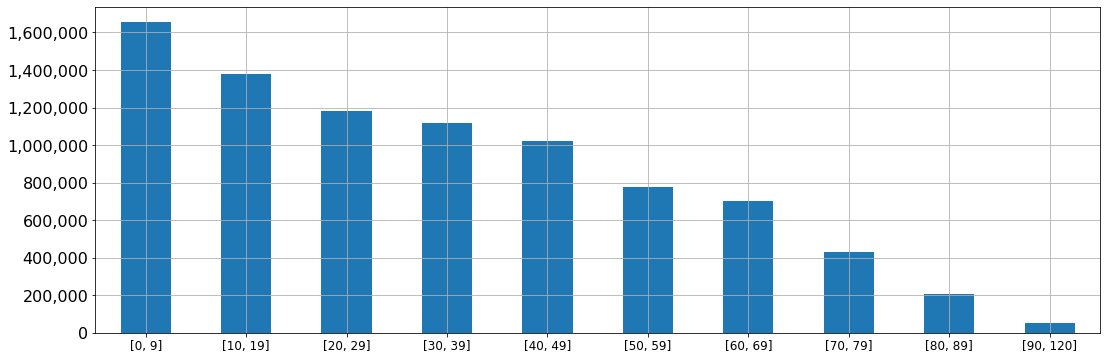

In [53]:
if is_title_off:
    title = None
ax = rougher_binning(age_pyramid, rates.index, 'sum').plot.bar(rot=0, title=title)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [54]:
((rougher_binning(age_pyramid, rates.index, 'sum')) / age_pyramid.sum()).plot.bar(rot=0, title='Israel population distribution by age group')

### normalization of CCFR by age group to gartner findings

In [55]:
rates['ccfr'] = rates['ccfr'] / ((rougher_binning(age_pyramid, rates.index, 'sum') / age_pyramid.sum()) * rates.ccfr).sum() * relative_rates_official[Status.dead]
#title = 'Confirmed Case Fatality Rate by age group'
title = 'שיעור תמותה מתוך כלל החולים המאומתים לפי קבוצת גיל'[::-1]
if is_title_off:
    title = None
ax = (100 * rates.ccfr).plot.bar(rot=0, title=title)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [56]:
rates_by_age_group = pd.DataFrame(index=rates.index, data=np.outer((rates / relative_rates_official[Status.dead]).values, relative_rates_official.values), columns=['ccer', 'ccsr', 'cchr', 'ccrr','ccfr'])[['cchr', 'ccrr', 'ccfr']].clip(upper=1)
rates_by_age_group

cchr      ccrr      ccfr
[0, 9]     0.000000  0.000000  0.000000
[10, 19]   0.000000  0.000000  0.000000
[20, 29]   0.006730  0.002355  0.000938
[30, 39]   0.006730  0.002355  0.000938
[40, 49]   0.006730  0.002355  0.000938
[50, 59]   0.023555  0.008244  0.003283
[60, 69]   0.151424  0.052999  0.021108
[70, 79]   0.461003  0.161351  0.064261
[80, 89]   0.834516  0.292081  0.116327
[90, 120]  0.847976  0.296792  0.118203

#### relative_rates for all population

In [57]:
_ = ((rougher_binning(age_pyramid, rates_by_age_group.index, 'sum') / age_pyramid.sum()).values[:, np.newaxis] * rates_by_age_group.values[:, :]).sum(axis=0)# * rates_by_age_group.ccfr)
relative_rates_mean_all_ages = relative_rates_template.copy()
relative_rates_mean_all_ages[Status.symptomatic] = 1
relative_rates_mean_all_ages[[Status.moderate_severe, Status.respirated, Status.dead]] = _
relative_rates_mean_all_ages

2       NaN
3    1.0000
4    0.0660
5    0.0231
6    0.0092
dtype: float64

In [58]:
relative_rates_official

2       NaN
3    1.0000
4    0.0660
5    0.0231
6    0.0092
dtype: float64

#### transformation rates according to HUJI model

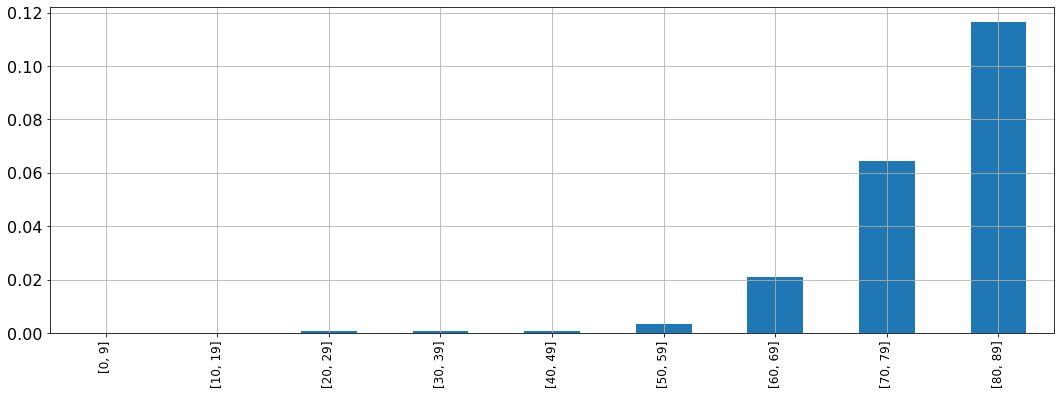

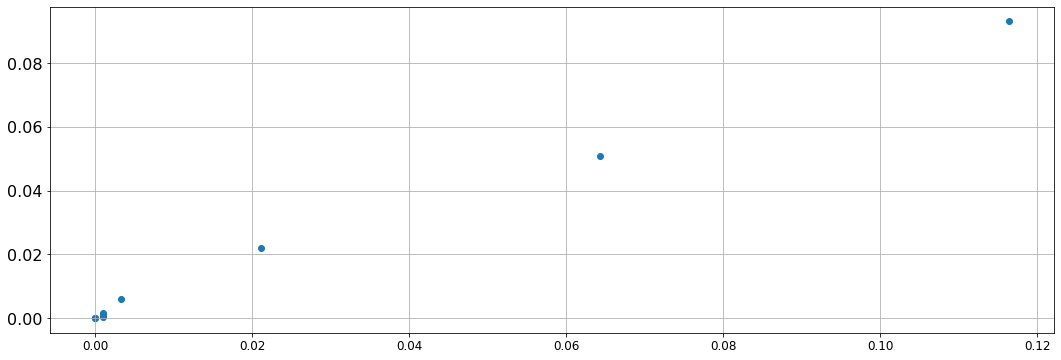

In [59]:
# Transformation Probabilities
# Probability of Detected Infected to become Hospitalized (A vector)
pIH = np.array([0.1, 0.3, 1.2, 3.2, 4.9, 10.2, 16.6, 24.3, 27.3]) * 1e-2 
# Probability of Hospitalized to become Critical (B vector)
pHC = np.array([5, 5, 5, 5, 6.3, 12.2, 27.4, 43.2, 70.9]) * 1e-2
# Probability of Critical to become Dead (Gamma vector)
pCD = np.array([40, 40, 50, 50, 48.6, 48.2, 48.4, 48.6, 48.1]) * 1e-2
HUJI_CCFR_by_age = pIH * pHC * pCD
pd.Series(HUJI_CCFR_by_age).plot.bar()
fig, ax = plt.subplots()
rates_by_age_group.ccfr.iloc[:-1].plot.bar()
fig, ax = plt.subplots()
ax.scatter(rates_by_age_group.ccfr.iloc[:-1].values, HUJI_CCFR_by_age)

#### define the population profile for each group

In [60]:
# source: https://brookdale.jdc.org.il/wp-content/uploads/2018/01/MJB-Facts-and-Figures-on-Elderly-in-Israel-2017_Hebrew.pdf
population_by_group_and_age = pd.DataFrame(index=age_pyramid.index, data=0, columns=['support', 'supplies', 'low', 'normal'])
population_by_group_and_age.support.loc[pd.Interval(65, 69, 'both') : pd.Interval(70, 74, 'both')] = age_pyramid * 0.07
population_by_group_and_age.support.loc[pd.Interval(75, 79, 'both'): ] = age_pyramid * 0.24
population_by_group_and_age.supplies.loc[pd.Interval(70, 74, 'both'):] = age_pyramid - population_by_group_and_age.support
population_by_group_and_age.low.loc[pd.Interval(60, 64, 'both'): pd.Interval(65, 69, 'both')] = age_pyramid - population_by_group_and_age.support - population_by_group_and_age.supplies
population_by_group_and_age['normal'] = age_pyramid - population_by_group_and_age.support - population_by_group_and_age.supplies - population_by_group_and_age.low
population_by_group_and_age = rougher_binning(population_by_group_and_age, rates.index, 'sum')
population_by_group_and_age
#population_by_group_and_age.sum(axis=0)

/home/ng/.local/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


support   supplies        low     normal
[0, 9]         0.00       0.00       0.00  1654530.0
[10, 19]       0.00       0.00       0.00  1377821.0
[20, 29]       0.00       0.00       0.00  1178880.0
[30, 39]       0.00       0.00       0.00  1117905.0
[40, 49]       0.00       0.00       0.00  1019070.0
[50, 59]       0.00       0.00       0.00   779142.0
[60, 69]   24536.05       0.00  677900.95        0.0
[70, 79]   57398.78  373473.22       0.00        0.0
[80, 89]   49446.72  156581.28       0.00        0.0
[90, 120]  12644.88   40042.12       0.00        0.0

#### compute age normilized rates for each group

In [61]:
rates_group = pd.DataFrame(index=population_by_group_and_age.columns, columns=rates_by_age_group.columns,
             data=((population_by_group_and_age / population_by_group_and_age.sum(axis=0)).values[:, :, np.newaxis] * rates_by_age_group.values[:, np.newaxis, :]).sum(axis=0)
).T

relative_rates_group = pd.concat([pd.DataFrame(columns=population_by_group_and_age.columns, data=[[None,] * 4, np.ones(4)]), rates_group])
relative_rates_group.index = relative_rates_template.index
relative_rates_group.loc[Status.exposed] = np.ones(4) / exposed_to_symptomatic_ratio


In [62]:
relative_rates_group

support  supplies       low    normal
2  2.000000  2.000000  2.000000  2.000000
3  1.000000  1.000000  1.000000  1.000000
4  0.570472  0.590771  0.151424  0.005706
5  0.199665  0.206770  0.052999  0.001997
6  0.079520  0.082350  0.021108  0.000795

transition_table = pd.DataFrame(index=None, columns=rel)

transitions = OrderedDict({
    SourceDestination(Status.exposed, Status.symptomatic) : TransitionAttributes(p=0.5, impulse_response=gamma_impulse_response(5.5, 2.3)),
    SourceDestination(Status.symptomatic, Status.moderate_severe) : TransitionAttributes(p=0.066, impulse_response=gamma_impulse_response(8.4, 4.9)),
    SourceDestination(Status.symptomatic, Status.respirated): TransitionAttributes(p=0.023, impulse_response=gamma_impulse_response(9.9, 5.6)),
    SourceDestination(Status.symptomatic, Status.dead): TransitionAttributes(p=0.0092, impulse_response=gamma_impulse_response(10.9, 6)),
})

transitions.update({
    SourceDestination(Status.symptomatic, Status.recover) : TransitionAttributes(p=1-0.066, impulse_response=delayed_uniform_impulse_response(7, 14)),
    SourceDestination(Status.moderate_severe, Status.recover) : TransitionAttributes(p=(0.066-0.023)/0.066, impulse_response=delayed_uniform_impulse_response(14, 28)),
    SourceDestination(Status.respirated, Status.recover) : TransitionAttributes(p=(0.023 - 0.0092)/0.023, impulse_response=delayed_uniform_impulse_response(7, 14)),
})

### normal group - not taking care of recovery yet

# trim age pyramid to relevant group, and normalize to 1
# normal group, up to age 70
def get_relative_rates_normalized_on_ages(age_pyramid, top_age_group, exposed_to_symptomatic_ratio, rates):
    age_pyramid_trim = rougher_binning(age_pyramid, rates.index)[:pd.Interval(60, 69, 'both')]
    age_pyramid_trim = age_pyramid_trim / age_pyramid_trim.sum()
    age_pyramid_trim

    # dot product of normalized age pyramid with IFR by age gives IFR for this group
    #_, _, _ = (rates[:pd.Interval(60, 69, 'both')].values * age_pyramid_trim.values[:, np.newaxis]).sum(axis=0)
    # load official model relative IFR, IHR (incidence hospitalization rate), IRR (incidence respiration rate)

    relative_rates = pd.DataFrame(relative_rates_template.copy(), columns=[GroupInteractions.normal])
    relative_rates[GroupInteractions.normal][[Status.exposed, Status.symptomatic]] = 1 / exposed_to_symptomatic_ratio, 1
    relative_rates[GroupInteractions.normal][[Status.moderate_severe, Status.respirated, Status.dead]] = (rates[:pd.Interval(60, 69, 'both')].values * age_pyramid_trim.values[:, np.newaxis]).sum(axis=0)
    return relative_rates
  

In [63]:
relative_rates_group.normal

2    2.000000
3    1.000000
4    0.005706
5    0.001997
6    0.000795
Name: normal, dtype: float64

#### compute transition probability for each source, dest, group

In [64]:
interactions_ratio_vec = pd.Series(index=population_by_group_and_age.columns, data=[0.5, 0.02, 0.1, 1])
interactions_ratio_vec

support     0.50
supplies    0.02
low         0.10
normal      1.00
dtype: float64

for g in list(GroupInteractions):
    groups[g] = groups[g]._replace(transitions = 
                                   compute_transitions_probability(transitions_template=transitions, relative_rates=relative_rates_group[g.value]))

#### groups with right transitions

In [65]:
groups2 = {}
for g in list(GroupInteractions):
    gn = g.value
    groups2[g] = GroupAttribues(size=population_by_group_and_age.sum(axis=0)[gn],
                                susceptible_0=population_by_group_and_age.sum(axis=0)[gn] * 1,
                                exposed_new_initial=groups[g].exposed_new_initial,
                                infector=groups[g].infector,
                                interactions_ratio=interactions_ratio_vec[gn],
                                transitions=compute_transitions_probability(transitions_template=transitions, relative_rates=relative_rates_group[g.value])
                               )

for group_interactions, attr in groups2.items():
    groups2[group_interactions] = attr._replace(infector_size=groups2[attr.infector].size)
    

In [66]:
[(g, attr.susceptible_0) for g, attr in groups2.items()]

[(<GroupInteractions.normal: 'normal'>, 7127348.0),
 (<GroupInteractions.low: 'low'>, 677900.95),
 (<GroupInteractions.supplies: 'supplies'>, 570096.62),
 (<GroupInteractions.support: 'support'>, 144026.43)]

In [67]:
groups2

{<GroupInteractions.normal: 'normal'>: GroupAttribues(size=7127348.0, susceptible_0=7127348.0, exposed_new_initial=array([ 4.,  0.,  6.,  2.,  8.,  4., 30.,  4., 40., 36.]), infector=<GroupInteractions.normal: 'normal'>, infector_size=7127348.0, interactions_ratio=1.0, transitions=OrderedDict([(SourceDestination(source=<Status.exposed: 2>, destination=<Status.symptomatic: 3>), TransitionAttribues(p=0.5, impulse_response=1 days     0.006004
 2 days     0.055882
 3 days     0.133842
 4 days     0.183890
 5 days     0.186328
 6 days     0.155721
 7 days     0.113944
 8 days     0.075645
 9 days     0.046623
 10 days    0.027100
 11 days    0.015022
 dtype: float64)), (SourceDestination(source=<Status.symptomatic: 3>, destination=<Status.moderate_severe: 4>), TransitionAttribues(p=0.005705938829480558, impulse_response=1 days     0.017569
 2 days     0.047473
 3 days     0.073436
 4 days     0.090406
 5 days     0.098207
 6 days     0.098564
 7 days     0.093664
 8 days     0.085520
 9 day

groups[GroupInteractions.normal] = groups[GroupInteractions.normal]._replace(transitions = transitions_normal)

age_pyramid_trim.values.reshape(-1, 1)

groups[GroupInteractions.normal].transitions[SourceDestination(Status.symptomatic, Status.dead)].p

In [68]:
dynamics, transitions_daily = epidemic_dynamics_with_passive_groups(N=350, R=2, infection_impulse_response=infection_impulse_response, groups=groups2)

/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected
  
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong
  """


In [69]:
rates_group

support  supplies       low    normal
cchr  0.570472  0.590771  0.151424  0.005706
ccrr  0.199665  0.206770  0.052999  0.001997
ccfr  0.079520  0.082350  0.021108  0.000795

status
exposed            5816652
symptomatic        2908326
moderate_severe      34673
respirated           12135
dead                  4833
recover            2903492
dtype: int64


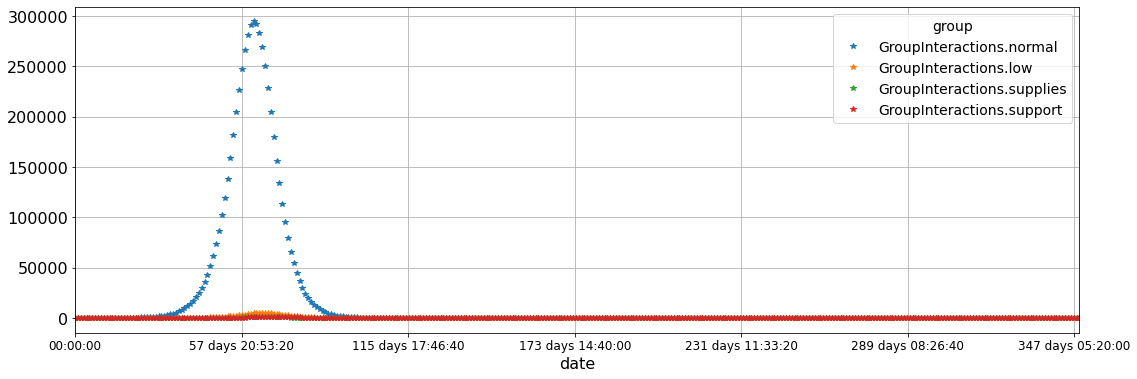

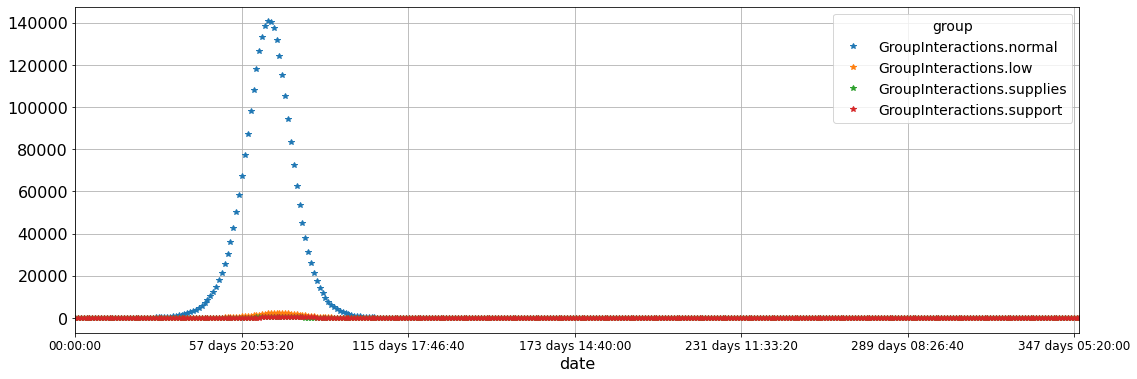

In [70]:
summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())
print(summary_table.astype(int))

ax = dynamics.xs(('exposed', 'new'), level=('status', 'attr'), axis=1).plot()

ax2 = dynamics.xs(('symptomatic', 'new'), level=('status', 'attr'), axis=1).plot()

ax3 = dynamics.xs(('moderate_severe', 'new'), level=('status', 'attr'), axis=1).plot()

In [71]:
dynamics.xs(('dead', 'new'), level=('status', 'attr'), axis=1).sum().sum()

4833.236722059635

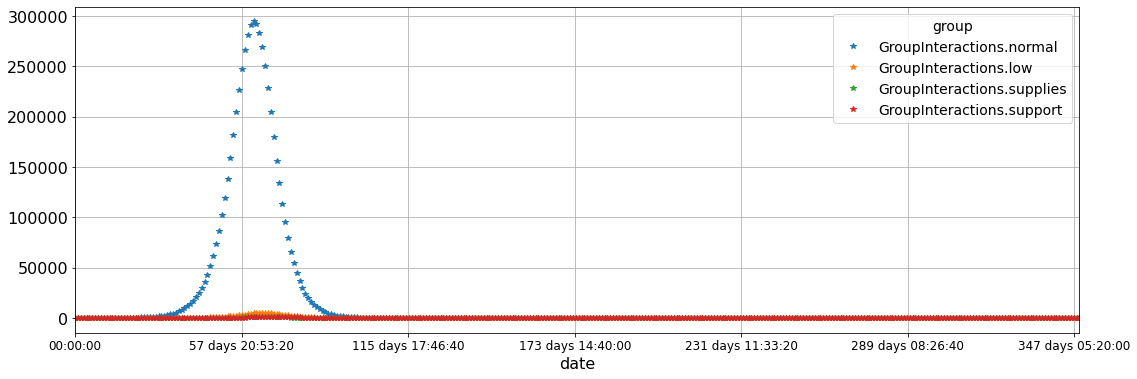

In [72]:
dynamics.xs(('exposed', 'new'), level=('status', 'attr'), axis=1).plot()

rates.ccfr

In [73]:
population_by_group_and_age.sum(axis=0)

support      144026.43
supplies     570096.62
low          677900.95
normal      7127348.00
dtype: float64

#### initialize groups

In [74]:
def initialize_epidemic_dynamics_with_passive_groups(
    N_steps, R, infection_impulse_response,
    groups_template, transitions_template,
    symptomatic_new_initial, exposed_to_symptomatic_ratio,
    population_by_group_and_age,
    interactions_ratio_vec,
    susceptible_ratio_vector,
    rates_by_age_group,
    infection_probability_ratio_vec=None,
    ):
      
    rates_group = pd.DataFrame(index=population_by_group_and_age.columns, columns=rates_by_age_group.columns,
             data=((population_by_group_and_age / population_by_group_and_age.sum(axis=0)).values[:, :, np.newaxis] * rates_by_age_group.values[:, np.newaxis, :]).sum(axis=0)).T
    relative_rates_group = pd.concat([pd.DataFrame(columns=population_by_group_and_age.columns, data=[[None,] * 4, np.ones(4)]), rates_group])
    relative_rates_group.index = relative_rates_template.index
    relative_rates_group.loc[Status.exposed] = np.ones(4) / exposed_to_symptomatic_ratio


    groups = {}
    for g in list(GroupInteractions):
        gn = g.value
        groups[g] = GroupAttribues(size=population_by_group_and_age.sum(axis=0)[gn],
                                    susceptible_0=population_by_group_and_age.sum(axis=0)[gn] * susceptible_ratio_vector[gn],
                                    exposed_new_initial=None,
                                    infector=groups_template[g].infector,
                                    interactions_ratio=interactions_ratio_vec[gn],
                                    transitions=compute_transitions_probability(transitions_template, relative_rates=relative_rates_group[gn])
                                   )
        if not infection_probability_ratio_vec is None:
            print(f'*********{infection_probability_ratio_vec[gn]}')
            groups[g] = groups[g]._replace(infection_probability_ratio=infection_probability_ratio_vec[gn])

    
    groups[GroupInteractions.normal] = groups[GroupInteractions.normal]._replace(exposed_new_initial=exposed_new_initial)
    
    for group_interactions, attr in groups.items():
        groups[group_interactions] = attr._replace(infector_size=groups[attr.infector].size)
    
    return N_steps, R, infection_impulse_response, groups

In [75]:
symptomatic_new_initial = symptomatic_new_initial.copy()
exposed_to_symptomatic_ratio = exposed_to_symptomatic_ratio
R = 1.35
N_steps = 350
#max_confirmed_cases_in_peak_countries = 0.6e-2
#susceptible_ratio_0 = estimate_susceptible_ratio(max_confirmed_cases_in_peak_countries, exposed_to_symptomatic_ratio)

susceptible_ratio_vector = pd.Series(index=population_by_group_and_age.columns, data=[1, 1, 1, 1])
interactions_ratio_vec = pd.Series(index=population_by_group_and_age.columns, data=[0.5, 0.02, 0.1, 1])
population_by_group_and_age = population_by_group_and_age
rates_by_age_group = rates_by_age_group
infection_impulse_response = infection_impulse_response
transitions_template = transitions_template
groups_template = groups.copy()


init = initialize_epidemic_dynamics_with_passive_groups(
    N_steps, R, infection_impulse_response,
    groups_template, transitions_template,
    symptomatic_new_initial, exposed_to_symptomatic_ratio,
    population_by_group_and_age,
    interactions_ratio_vec,
    susceptible_ratio_vector,
    rates_by_age_group
    )

dynamics, _ =  epidemic_dynamics_with_passive_groups(*init)
summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())
#N=200, R=2, infection_impulse_response=infection_impulse_response, groups=groups2)

#prediction, _ = myfunc(*initialize(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates))

/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected
  
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong
  """


In [76]:
summary_table.astype(int)

status
exposed            3399614
symptomatic        1699807
moderate_severe      16482
respirated            5768
dead                  2297
recover            1697509
dtype: int64

### the same with infection probability ratio

In [77]:
symptomatic_new_initial = symptomatic_new_initial.copy()
exposed_to_symptomatic_ratio = exposed_to_symptomatic_ratio
R = 1.35
N_steps = 350
#max_confirmed_cases_in_peak_countries = 0.6e-2
#susceptible_ratio_0 = estimate_susceptible_ratio(max_confirmed_cases_in_peak_countries, exposed_to_symptomatic_ratio)

susceptible_ratio_vector = pd.Series(index=population_by_group_and_age.columns, data=[1, 1, 1, 1])
interactions_ratio_vec = pd.Series(index=population_by_group_and_age.columns, data=[0.5, 0.02, 0.1, 1])
infection_probability_ratio_vec = pd.Series(index=population_by_group_and_age.columns, data=[0.5, 0.5, 0.5, 0.9])
population_by_group_and_age = population_by_group_and_age
rates_by_age_group = rates_by_age_group
infection_impulse_response = infection_impulse_response
transitions_template = transitions_template
groups_template = groups.copy()


init = initialize_epidemic_dynamics_with_passive_groups(
    N_steps, R, infection_impulse_response,
    groups_template, transitions_template,
    symptomatic_new_initial, exposed_to_symptomatic_ratio,
    population_by_group_and_age,
    interactions_ratio_vec,
    susceptible_ratio_vector,
    rates_by_age_group,
    infection_probability_ratio_vec
    )

dynamics, _ =  epidemic_dynamics_with_passive_groups(*init)
summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())
#N=200, R=2, infection_impulse_response=infection_impulse_response, groups=groups2)

#prediction, _ = myfunc(*initialize(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates))

*********0.9
*********0.5
*********0.5
*********0.5


/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: susceptible exposed time propagation did not converge R1.35 interactions_ratio1.0 N_steps350 exposed_new step -30 43.219363567740174 exposed_new step -1 9.173031691506099
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected
  
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong
  """


In [78]:
init[-1][GroupInteractions.normal].infection_probability_ratio

0.9

In [79]:
summary_table.astype(int)

status
exposed            2382845
symptomatic        1191393
moderate_severe       8938
respirated            3128
dead                  1246
recover            1190054
dtype: int64

### checking a certain quality of the model

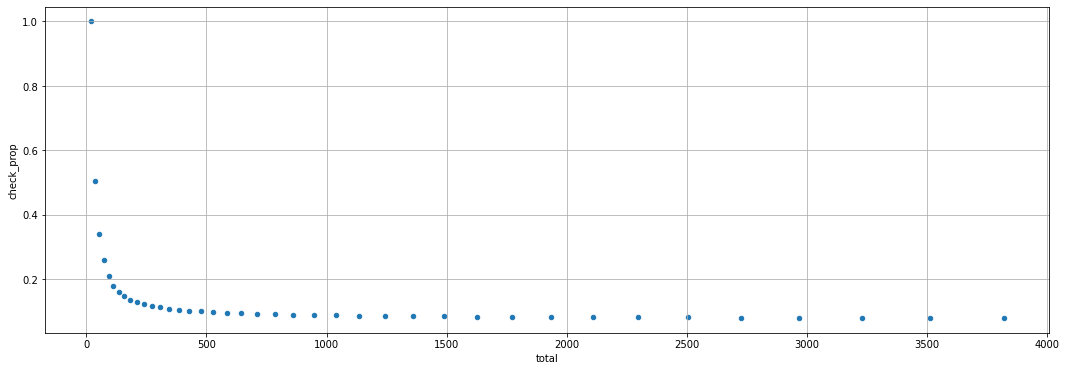

In [73]:
A = dynamics[GroupInteractions.normal]['symptomatic'].iloc[20:60]
A['total'] = A.net_delta.cumsum()
A['check_prop'] = (A.net_delta / A.total)

A.plot.scatter('total', 'check_prop')

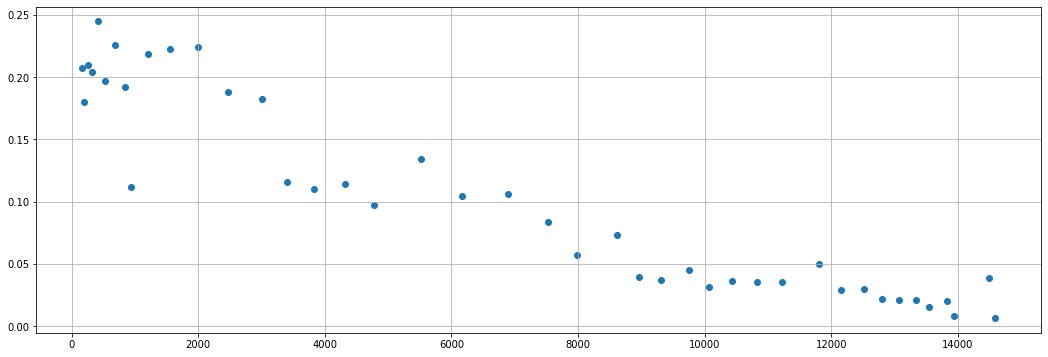

In [74]:
fig, ax = plt.subplots()
confirmed2 = confirmed.iloc[20:]
ax.scatter(confirmed2.cases_tot, confirmed2.cases_tot.diff() / confirmed2.cases_tot)

## produce summary table for different scenarios

In [354]:
summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())

### scenario of 20% susceptible, R~5, PD=50%, very interesting, around critical behavior. Linear up, linear down

In [168]:
import warnings

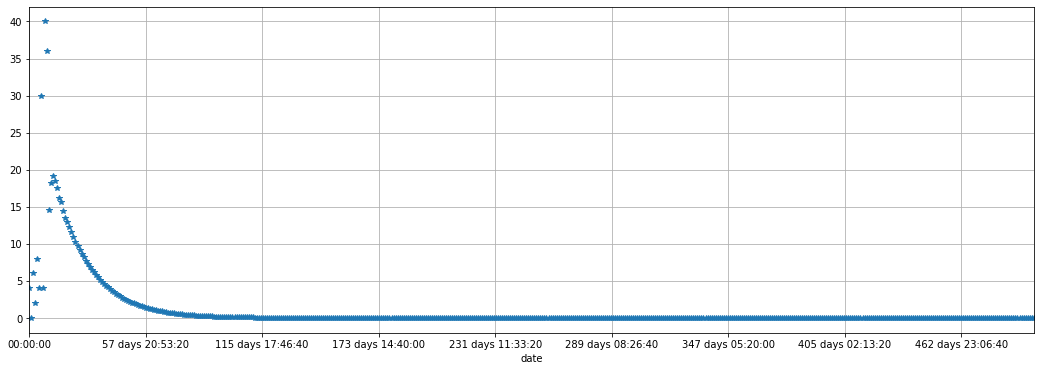

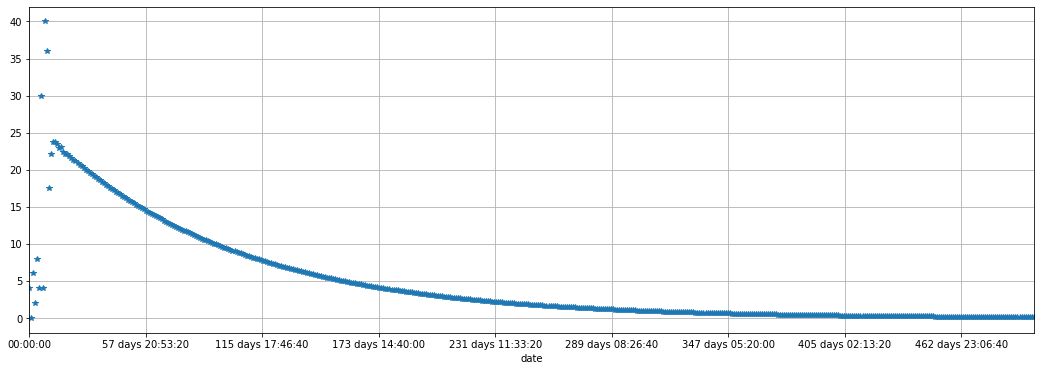

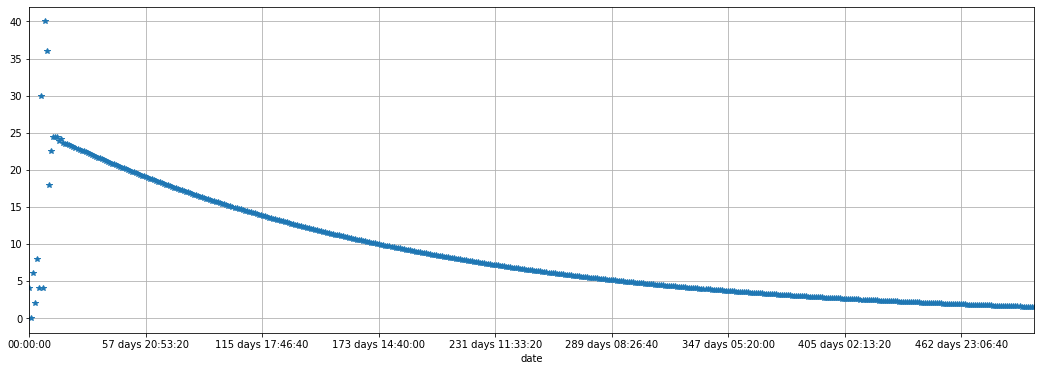

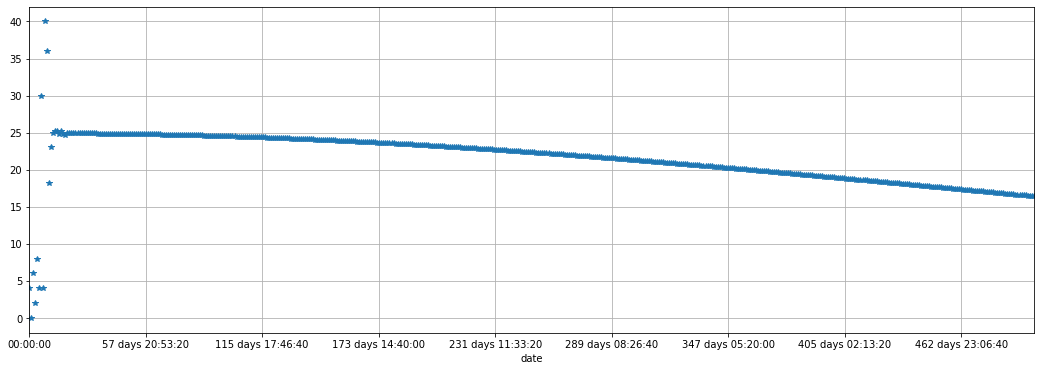

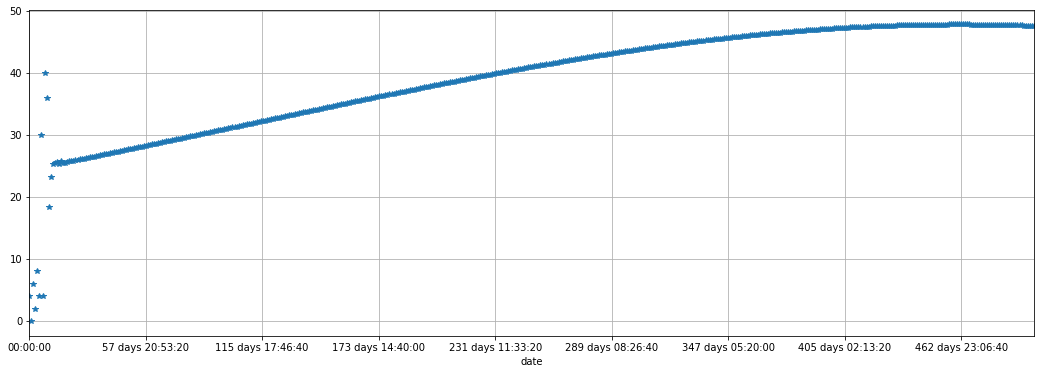

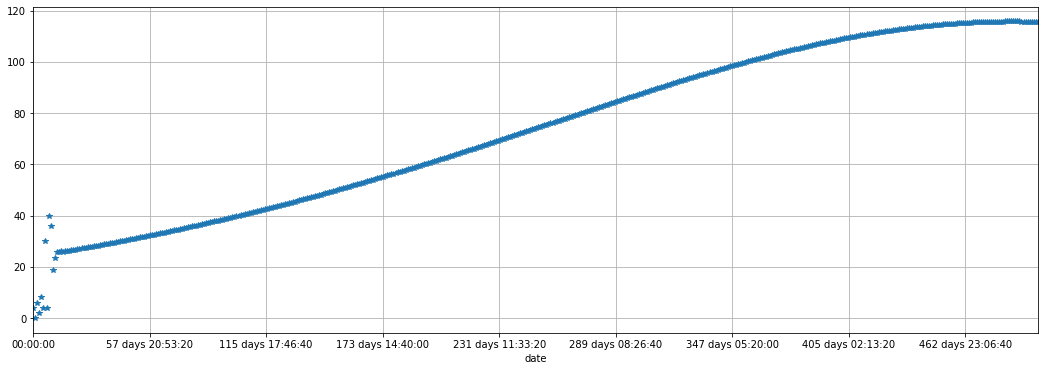

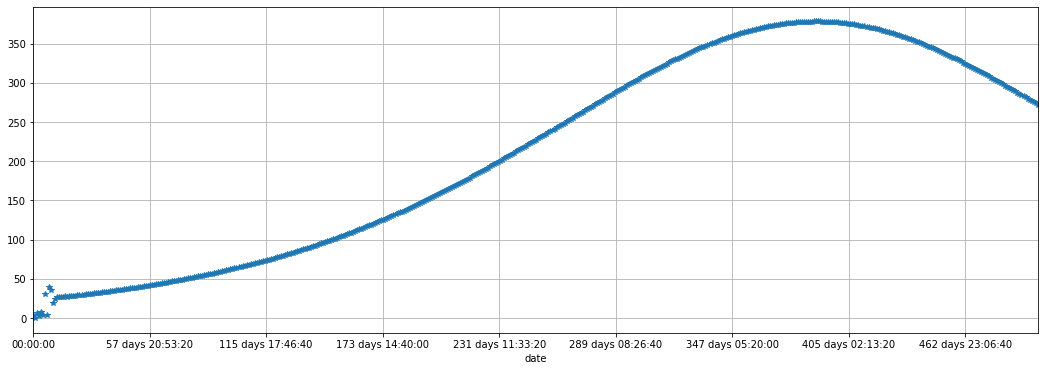

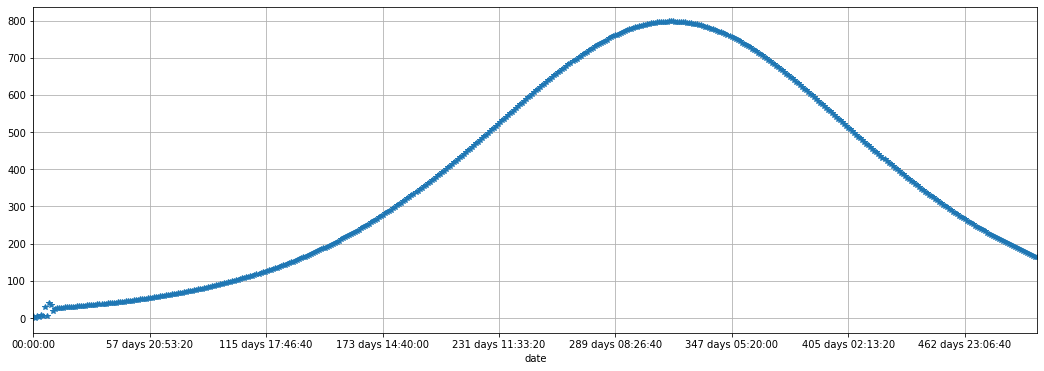

In [221]:
N_steps = 500
susceptible_ratio = 0.2
population = 9e6
relative_rates = relative_rates_official
infection_impulse_response = infection_impulse_response

#R_to_check = [1.35, ]#
R_to_check = [4, 4.8, 4.9, 5, 5.05, 5.08, 5.1, 5.2, 5.3,]
#PD_to_check = [0.5, ]#[0.1, 0.3, 0.5, 0.7, 0.9]
PD_to_check = [0.5,]


summary_table_many = {}
for R, exposed_to_symptomatic_ratio in itertools.product(R_to_check, PD_to_check):
    dynamics, _ = epidemic_dynamics(*initialize_epidemic_dynamics(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates))
    summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())#collect_summary_table
    summary_table_many[(R, exposed_to_symptomatic_ratio)] = summary_table
    fig, ax = plt.subplots()
    #dynamics.symptomatic.net_delta.cumsum().plot(ax=ax)
    dynamics.exposed.new.plot(ax=ax)

summary_table_all_scenarios = pd.concat(summary_table_many, names=['R', 'PD'], axis=1).T
if False:
    summary_table_all_scenarios.to_csv(path_results.joinpath('MOH_model_MOH_params.csv'))

### scenario of 40% susceptible, R~5, PD=50%

In [355]:
import itertools

In [83]:
N_steps = 200
susceptible_ratio = 0.4
population = 9e6
relative_rates = relative_rates_official
infection_impulse_response = infection_impulse_response

#R_to_check = [1.35, ]#
R_to_check = [5,]
#PD_to_check = [0.5, ]#[0.1, 0.3, 0.5, 0.7, 0.9]
PD_to_check = [0.5,]


summary_table_many = {}
for R, exposed_to_symptomatic_ratio in itertools.product(R_to_check, PD_to_check):
    dynamics, _ = epidemic_dynamics(*initialize_epidemic_dynamics(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates))
    summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())#collect_summary_table
    summary_table_many[(R, exposed_to_symptomatic_ratio)] = summary_table
    #fig, ax = plt.subplots()
    #dynamics.symptomatic.net_delta.cumsum().plot(ax=ax)
    #dynamics.exposed.new.plot(ax=ax)

summary_table_all_scenarios = pd.concat(summary_table_many, names=['R', 'PD'], axis=1).T
if False:
    summary_table_all_scenarios.to_csv(path_results.joinpath('MOH_model_MOH_params.csv'))

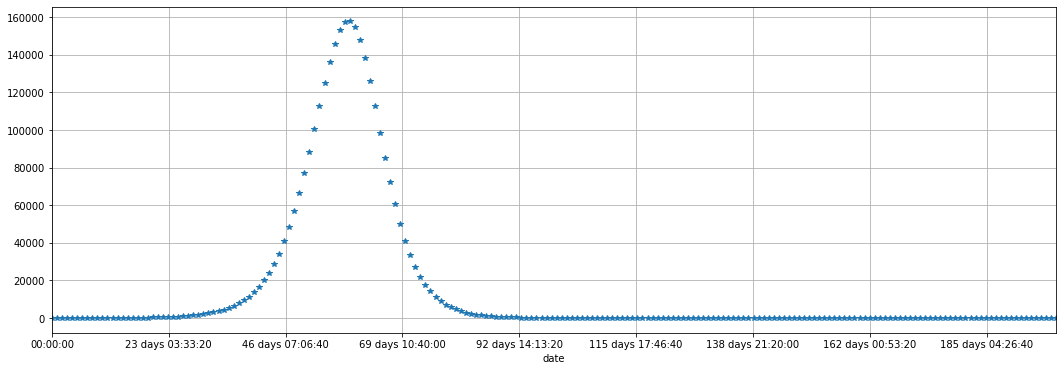

In [84]:
dynamics.exposed.new.plot()

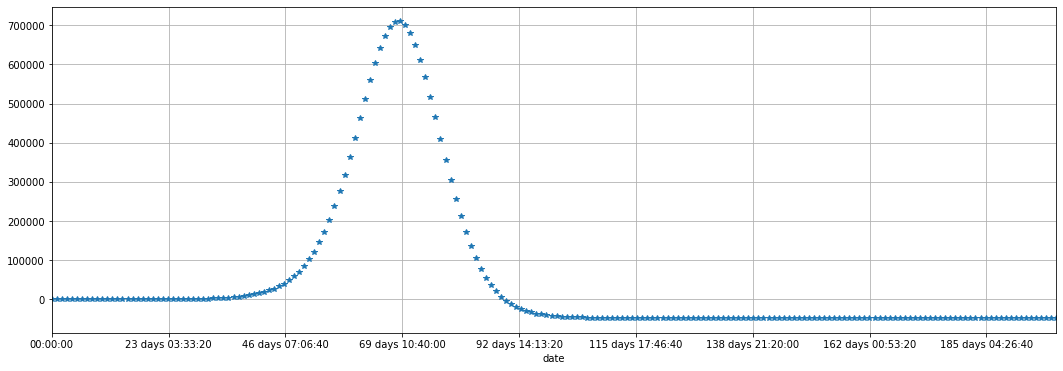

In [85]:
dynamics.symptomatic.net_delta.cumsum().plot()

### comparison of the details of the dynamics for MOH model and our model in official scenario R=1.35 PD=0.5

In [388]:
R = 1.35
exposed_to_symptomatic_ratio = 0.5
N_steps = 500
susceptible_ratio = 1
infection_impulse_response = infection_impulse_response


In [391]:
population = age_pyramid.sum()
relative_rates = relative_rates_official

dynamics_MOH, _ = epidemic_dynamics(*initialize_epidemic_dynamics(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates))
summary_table_MOH = dynamics_MOH.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())#collect_summary_table

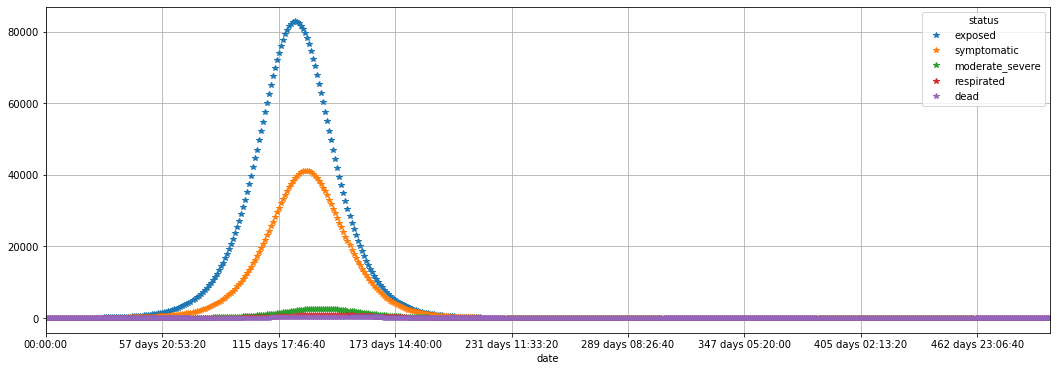

In [407]:
dynamics_MOH.xs(('new',), level=('attr',), axis=1)[['exposed', 'symptomatic', 'moderate_severe', 'respirated', 'dead']].plot()

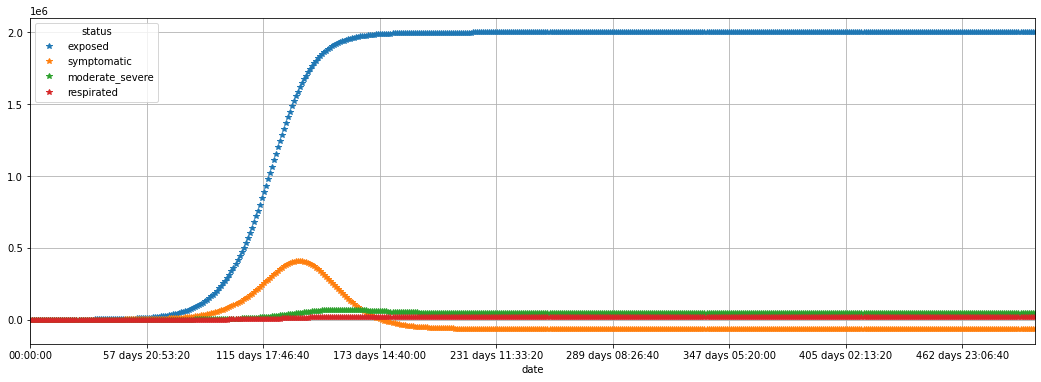

In [409]:
dynamics_MOH.xs(('net_delta',), level=('attr',), axis=1).cumsum()[['exposed', 'symptomatic', 'moderate_severe', 'respirated']].plot()

In [ ]:
symptomatic_new_initial = symptomatic_new_initial.copy()

susceptible_ratio_vector = pd.Series(index=population_by_group_and_age.columns, data=[1, 1, 1, 1])
interactions_ratio_vec = pd.Series(index=population_by_group_and_age.columns, data=[0.5, 0.02, 0.1, 1])
population_by_group_and_age = population_by_group_and_age
rates_by_age_group = rates_by_age_group
infection_impulse_response = infection_impulse_response
transitions_template = transitions_template
groups_template = groups.copy()




init = initialize_epidemic_dynamics_with_passive_groups(
    N_steps, R, infection_impulse_response,
    groups_template, transitions_template,
    symptomatic_new_initial, exposed_to_symptomatic_ratio,
    population_by_group_and_age,
    interactions_ratio_vec,
    susceptible_ratio_vector,
    rates_by_age_group
    )

dynamics, _ =  epidemic_dynamics_with_passive_groups(*init)
summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())

### assumptions like official MOH

In [86]:
import itertools


In [357]:
IS_SAVE_RESULTS = True
path_results = Path('../analysis_results/epidemic_models')

In [358]:
N_steps = 500
susceptible_ratio = 1
population = age_pyramid.sum()
relative_rates = relative_rates_official
infection_impulse_response = infection_impulse_response

if False:
    R_to_check = [1.2, ]
    PD_to_check = [0.9, ]#[0.1, 0.3, 0.5, 0.7, 0.9]

if True:
    R_to_check = [1.2, 1.35, 1.5, 1.7, 2]
    PD_to_check = [0.1, 0.3, 0.5, 0.7, 0.9]


summary_table_many = {}
for R, exposed_to_symptomatic_ratio in itertools.product(R_to_check, PD_to_check):
    dynamics, _ = epidemic_dynamics(*initialize_epidemic_dynamics(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates))
    summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())#collect_summary_table
    summary_table_many[(R, exposed_to_symptomatic_ratio)] = summary_table

summary_table_all_scenarios = pd.concat(summary_table_many, names=['R', 'PD'], axis=1).T
if IS_SAVE_RESULTS:
    summary_table_all_scenarios.to_csv(path_results.joinpath('MOH_model_MOH_params.csv'))

In [359]:
dynamics.xs('new', level='attr', axis=1)#.sum(axis=0)

status     exposed  symptomatic  moderate_severe  respirated          dead  \
date                                                                         
0 days    2.222222     0.000000         0.000000    0.000000  0.000000e+00   
1 days    0.000000     0.012008         0.000000    0.000000  0.000000e+00   
2 days    3.333333     0.111763         0.000014    0.000003  6.129240e-07   
3 days    1.111111     0.285695         0.000167    0.000032  7.935002e-06   
4 days    4.444444     0.541429         0.000740    0.000149  3.952816e-05   
...            ...          ...              ...         ...           ...   
495 days  0.000000     0.000000         0.000000    0.000000  0.000000e+00   
496 days  0.000000     0.000000         0.000000    0.000000  0.000000e+00   
497 days  0.000000     0.000000         0.000000    0.000000  0.000000e+00   
498 days  0.000000     0.000000         0.000000    0.000000  0.000000e+00   
499 days  0.000000     0.000000         0.000000    0.000000  0.000000e+00   

status    recover  
date               
0 days        0.0  
1 days        0.0  
2 days        0.0  
3 days        0.0  
4 days        0.0  
...           ...  
495 days      0.0  
496 days      0.0  
497 days      0.0  
498 days      0.0  
499 days      0.0  

[500 rows x 6 columns]

In [360]:
summary_table

status
exposed            6.788350e+06
symptomatic        6.109515e+06
moderate_severe    4.032280e+05
respirated         1.411298e+05
dead               5.620754e+04
recover            6.053307e+06
dtype: float64

In [113]:
dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())


status
exposed            2.691202e+06
symptomatic        2.421768e+06
moderate_severe    1.597917e+05
respirated         5.592331e+04
dead               2.227154e+04
recover            2.398342e+06
dtype: float64

In [112]:
dynamics

status      exposed symptomatic moderate_severe respirated          dead  \
attr            new         new             new        new           new   
date                                                                       
0 days     2.222222    0.000000        0.000000   0.000000  0.000000e+00   
1 days     0.000000    0.012008        0.000000   0.000000  0.000000e+00   
2 days     3.333333    0.111763        0.000014   0.000003  6.129240e-07   
3 days     1.111111    0.285695        0.000167   0.000032  7.935002e-06   
4 days     4.444444    0.541429        0.000740   0.000149  3.952816e-05   
...             ...         ...             ...        ...           ...   
345 days  69.111316   82.169430        8.287037   3.140941  1.311403e+00   
346 days  65.695178   78.109206        7.877883   2.985897  1.246678e+00   
347 days  62.447737   74.249353        7.488888   2.838489  1.185139e+00   
348 days  59.360679   70.580009        7.119064   2.698343  1.126632e+00   
349 days  56.426096   67.091793        6.767469   2.565103  1.071006e+00   

status       recover    exposed symptomatic moderate_severe respirated  
attr             new  net_delta   net_delta       net_delta  net_delta  
date                                                                    
0 days      0.000000   2.222222    0.000000        0.000000   0.000000  
1 days      0.000000  -0.012008    0.012008        0.000000   0.000000  
2 days      0.000000   3.221570    0.111746        0.000014   0.000003  
3 days      0.000000   0.825416    0.285488        0.000167   0.000032  
4 days      0.000000   3.903015    0.540501        0.000740   0.000149  
...              ...        ...         ...             ...        ...  
345 days  154.269157 -13.058114  -65.230236       -8.008362  -0.172532  
346 days  146.658016 -12.414028  -62.014479       -7.616695  -0.164314  
347 days  139.421354 -11.801616  -58.956700       -7.243967  -0.156472  
348 days  132.540847 -11.219330  -56.049194       -6.889285  -0.148991  
349 days  125.999055 -10.665697  -53.284622       -6.551793  -0.141854  

[350 rows x 10 columns]

In [106]:
#dynamics.exposed.new.plot()

### MOH model with assuming CCFR by age data

In [91]:
#susceptible_ratio = estimate_susceptible_ratio(max_confirmed_cases_in_peak_countries, exposed_to_symptomatic_ratio)

In [361]:
N_steps = 500
population = age_pyramid.sum()
relative_rates = relative_rates_mean_all_ages
infection_impulse_response = infection_impulse_response
susceptible_ratio = 1

if False:
    R_to_check = [1.2, ]
    PD_to_check = [0.9, ]#[0.1, 0.3, 0.5, 0.7, 0.9]

if True:
    R_to_check = [1.2, 1.35, 1.5, 1.7, 2]
    PD_to_check = [0.1, 0.3, 0.5, 0.7, 0.9]


summary_table_many = {}
for R, exposed_to_symptomatic_ratio in itertools.product(R_to_check, PD_to_check):
    dynamics, _ = epidemic_dynamics(*initialize_epidemic_dynamics(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates))
    summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())#collect_summary_table
    summary_table_many[(R, exposed_to_symptomatic_ratio)] = summary_table

summary_table_all_scenarios = pd.concat(summary_table_many, names=['R', 'PD'], axis=1).T
if IS_SAVE_RESULTS:
    summary_table_all_scenarios.to_csv(path_results.joinpath('MOH_model_CCFR_by_age.csv'))

In [362]:
summary_table_all_scenarios

status         exposed   symptomatic  moderate_severe     respirated  \
R    PD                                                                
1.20 0.1  2.674210e+06  2.674210e+05     17649.786124    6177.425117   
     0.3  2.673079e+06  8.019236e+05     52926.952694   18524.433194   
     0.5  2.672852e+06  1.336426e+06     88204.106601   30871.436608   
     0.7  2.672755e+06  1.870928e+06    123481.251640   43218.436682   
     0.9  2.672701e+06  2.405431e+06    158758.388173   55565.433544   
1.35 0.1  3.998850e+06  3.998850e+05     26392.408993    9237.343148   
     0.3  3.998341e+06  1.199502e+06     79167.161331   27708.506466   
     0.5  3.998240e+06  1.999120e+06    131941.913043   46179.669565   
     0.7  3.998196e+06  2.798737e+06    184716.664667   64650.832633   
     0.9  3.998172e+06  3.598355e+06    237491.416261   83121.995691   
1.50 0.1  4.965611e+06  4.965611e+05     32773.032544   11470.561391   
     0.3  4.965330e+06  1.489599e+06     98313.530150   34409.735552   
     0.5  4.965274e+06  2.482637e+06    163854.027623   57348.909668   
     0.7  4.965249e+06  3.475675e+06    229394.525077   80288.083777   
     0.9  4.965236e+06  4.468712e+06    294935.022526  103227.257884   
1.70 0.1  5.888692e+06  5.888692e+05     38865.365744   13602.878010   
     0.3  5.888545e+06  1.766563e+06    116593.183881   40807.614358   
     0.5  5.888515e+06  2.944258e+06    194321.002009   68012.350703   
     0.7  5.888503e+06  4.121952e+06    272048.820136   95217.087048   
     0.9  5.888496e+06  5.299646e+06    349776.638263  122421.823392   
2.00 0.1  6.788435e+06  6.788435e+05     44803.672289   15681.285301   
     0.3  6.788371e+06  2.036511e+06    134409.746406   47043.411242   
     0.5  6.788358e+06  3.394179e+06    224015.820539   78405.537189   
     0.7  6.788353e+06  4.751847e+06    313621.894674  109767.663136   
     0.9  6.788350e+06  6.109515e+06    403227.968810  141129.789083   

status            dead       recover  
R    PD                               
1.20 0.1   2460.273200  2.649607e+05  
     0.3   7377.696274  7.945458e+05  
     0.5  12295.117433  1.324131e+06  
     0.7  17212.537203  1.853715e+06  
     0.9  22129.955634  2.383300e+06  
1.35 0.1   3678.941860  3.962060e+05  
     0.3  11035.422489  1.188467e+06  
     0.5  18391.903030  1.980728e+06  
     0.7  25748.383560  2.772989e+06  
     0.9  33104.864085  3.565250e+06  
1.50 0.1   4568.362112  4.919927e+05  
     0.3  13704.310263  1.475895e+06  
     0.5  22840.258396  2.459797e+06  
     0.7  31976.206526  3.443698e+06  
     0.9  41112.154655  4.427600e+06  
1.70 0.1   5417.596437  5.834516e+05  
     0.3  16252.383208  1.750311e+06  
     0.5  27087.169977  2.917170e+06  
     0.7  37921.956746  4.084030e+06  
     0.9  48756.743516  5.250889e+06  
2.00 0.1   6245.360380  6.725982e+05  
     0.3  18735.904045  2.017775e+06  
     0.5  31226.447712  3.362953e+06  
     0.7  43716.991379  4.708130e+06  
     0.9  56207.535046  6.053307e+06

### assuming CCFR by age and also that people in high risk profile reduce interactions

In [363]:
symptomatic_new_initial = symptomatic_new_initial.copy()
N_steps = 500
#max_confirmed_cases_in_peak_countries = 0.6e-2
#susceptible_ratio_0 = estimate_susceptible_ratio(max_confirmed_cases_in_peak_countries, exposed_to_symptomatic_ratio)

susceptible_ratio_vector = pd.Series(index=population_by_group_and_age.columns, data=[1, 1, 1, 1])
interactions_ratio_vec = pd.Series(index=population_by_group_and_age.columns, data=[0.5, 0.02, 0.1, 1])
population_by_group_and_age = population_by_group_and_age
rates_by_age_group = rates_by_age_group
infection_impulse_response = infection_impulse_response
transitions_template = transitions_template
groups_template = groups.copy()



if False:
    R_to_check = [1.2, ]
    PD_to_check = [0.9, ]#[0.1, 0.3, 0.5, 0.7, 0.9]

if True:
    R_to_check = [1.2, 1.35, 1.5, 1.7, 2]
    PD_to_check = [0.1, 0.3, 0.5, 0.7, 0.9]




summary_table_many = {}
for R, exposed_to_symptomatic_ratio in itertools.product(R_to_check, PD_to_check):
    init = initialize_epidemic_dynamics_with_passive_groups(
        N_steps, R, infection_impulse_response,
        groups_template, transitions_template,
        symptomatic_new_initial, exposed_to_symptomatic_ratio,
        population_by_group_and_age,
        interactions_ratio_vec,
        susceptible_ratio_vector,
        rates_by_age_group
        )

    dynamics, _ =  epidemic_dynamics_with_passive_groups(*init)
    summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())
    summary_table_many[(R, exposed_to_symptomatic_ratio)] = summary_table

summary_table_all_scenarios = pd.concat(summary_table_many, names=['R', 'PD'], axis=1).T
if IS_SAVE_RESULTS:
    summary_table_all_scenarios.to_csv(path_results.joinpath('passive_groups_CCFR_by_age.csv'))




In [124]:
#dynamics[GroupInteractions.normal].exposed.new.plot()

In [281]:
summary_table_all_scenarios

status         exposed   symptomatic  moderate_severe    respirated  \
R    PD                                                               
1.20 0.1  1.676905e+06  1.548205e+05      2463.632295    862.573360   
     0.3  1.676905e+06  4.644615e+05      7390.896885   2587.720081   
     0.5  1.676905e+06  7.741024e+05     12318.161476   4312.866802   
     0.7  1.676905e+06  1.083743e+06     17245.426066   6038.013523   
     0.9  1.676905e+06  1.393384e+06     22172.690656   7763.160243   
1.35 0.1  3.433972e+06  3.431411e+05      6723.086994   2443.968650   
     0.3  3.433972e+06  1.029423e+06     20169.260982   7331.905950   
     0.5  3.433972e+06  1.715706e+06     33615.434970  12219.843250   
     0.7  3.433972e+06  2.401988e+06     47061.608958  17107.780550   
     0.9  3.433972e+06  3.088270e+06     60507.782946  21995.717850   
1.50 0.1  4.289934e+06  4.289920e+05      8756.141178   3199.332824   
     0.3  4.289934e+06  1.286976e+06     26268.423534   9597.998472   
     0.5  4.289934e+06  2.144960e+06     43780.705891  15996.664121   
     0.7  4.289934e+06  3.002944e+06     61292.988247  22395.329769   
     0.9  4.289934e+06  3.860928e+06     78805.270603  28793.995417   
1.70 0.1  5.113905e+06  5.113905e+05     10967.171670   4029.368743   
     0.3  5.113905e+06  1.534172e+06     32901.515009  12088.106230   
     0.5  5.113905e+06  2.556953e+06     54835.858349  20146.843716   
     0.7  5.113905e+06  3.579734e+06     76770.201688  28205.581203   
     0.9  5.113905e+06  4.602515e+06     98704.545028  36264.318689   
2.00 0.1  5.930003e+06  5.930003e+05     13654.115055   5055.677294   
     0.3  5.930003e+06  1.779001e+06     40962.345166  15167.031881   
     0.5  5.930003e+06  2.965001e+06     68270.575276  25278.386468   
     0.7  5.930003e+06  4.151002e+06     95578.805387  35389.741055   
     0.9  5.930003e+06  5.337002e+06    122887.035497  45501.095642   

status            dead       recover  
R    PD                               
1.20 0.1    336.925334  1.242506e+05  
     0.3   1010.776003  3.727519e+05  
     0.5   1684.626672  6.212531e+05  
     0.7   2358.477341  8.697544e+05  
     0.9   3032.328010  1.118256e+06  
1.35 0.1    972.877426  3.409569e+05  
     0.3   2918.632277  1.022871e+06  
     0.5   4864.387129  1.704785e+06  
     0.7   6810.141981  2.386698e+06  
     0.9   8755.896832  3.068612e+06  
1.50 0.1   1274.187751  4.277073e+05  
     0.3   3822.563252  1.283122e+06  
     0.5   6370.938754  2.138537e+06  
     0.7   8919.314255  2.993951e+06  
     0.9  11467.689757  3.849366e+06  
1.70 0.1   1604.770224  5.097857e+05  
     0.3   4814.310673  1.529357e+06  
     0.5   8023.851122  2.548929e+06  
     0.7  11233.391571  3.568500e+06  
     0.9  14442.932019  4.588072e+06  
2.00 0.1   2013.516498  5.909867e+05  
     0.3   6040.549494  1.772960e+06  
     0.5  10067.582489  2.954934e+06  
     0.7  14094.615485  4.136907e+06  
     0.9  18121.648481  5.318881e+06

### some comparisons

In [575]:
summary_table_all_scenarios_MOH = pd.read_csv(path_results.joinpath('MOH_model_MOH_params.csv'), index_col=[0, 1])
summary_table_all_scenarios_MOH_CCFR_by_age = pd.read_csv(path_results.joinpath('MOH_model_CCFR_by_age.csv'), index_col=[0, 1])
summary_table_all_scenarios_passive_groups_CCFR_by_age = pd.read_csv(path_results.joinpath('passive_groups_CCFR_by_age.csv'), index_col=[0, 1])

PD_display = [0.3, 0.5, 0.7]
R_display = [1.2, 1.35, 2]
summary_table_all_scenarios_MOH = summary_table_all_scenarios_MOH.loc[(R_display, PD_display),:]
summary_table_all_scenarios_MOH_CCFR_by_age = summary_table_all_scenarios_MOH_CCFR_by_age.loc[(R_display, PD_display),:]
summary_table_all_scenarios_passive_groups_CCFR_by_age = summary_table_all_scenarios_passive_groups_CCFR_by_age.loc[(R_display, PD_display),:]

#index_temp = summary_table_all_scenarios_MOH.index.to_frame()
#index_temp.R = index_temp.R / 0.75
#summary_table_all_scenarios_MOH.index = pd.MultiIndex.from_frame(index_temp)
summary_table_all_scenarios_MOH.index = summary_table_all_scenarios_MOH_CCFR_by_age.index

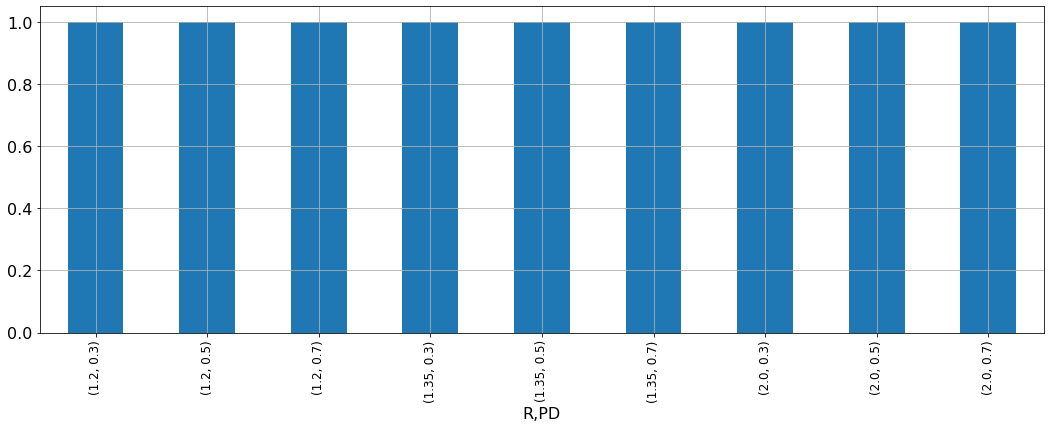

In [576]:
np.round((summary_table_all_scenarios_MOH_CCFR_by_age / summary_table_all_scenarios_MOH), 3).dead.plot.bar()

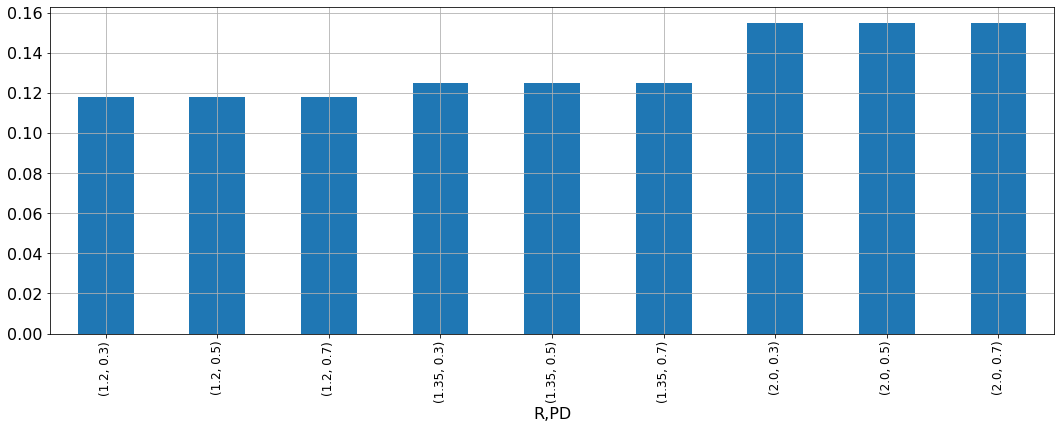

In [577]:
np.round((summary_table_all_scenarios_passive_groups_CCFR_by_age / summary_table_all_scenarios_MOH_CCFR_by_age), 3).dead.plot.bar()

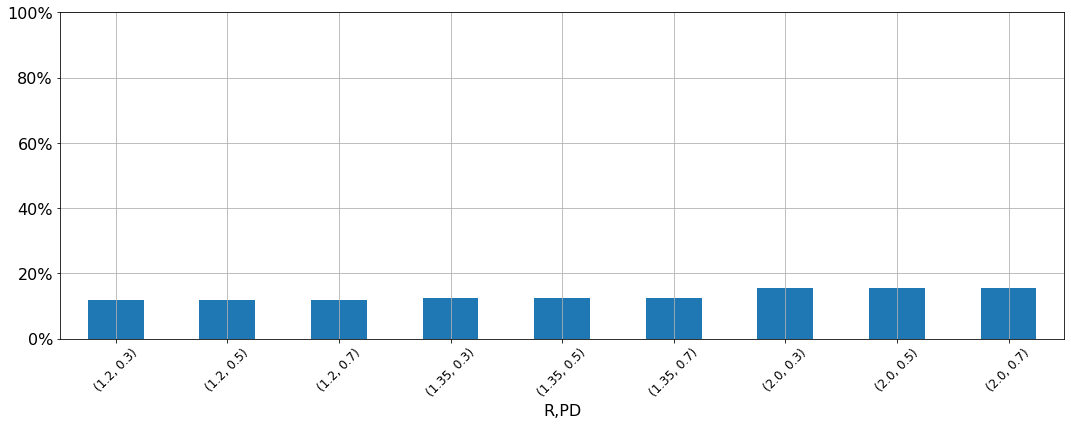

In [578]:
ratios = np.round((summary_table_all_scenarios_passive_groups_CCFR_by_age / summary_table_all_scenarios_MOH), 3)

title='יעילות הגנה על אוכלוסיות סיכון: השוואת תמותה כוללת לתמותה במודל הייחוס במגוון תרחישים'[::-1]
if is_title_off:
    title = None

ax = (100 * ratios).dead.plot.bar(rot=45, title=title)
ax.set_ylim((0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())


In [564]:
ratios.to_csv(path_results.joinpath('passive_groups_to_MOH_ratio.csv'))
ratios_percent = ((np.round(100 * ratios, 2)).astype(str) + '%').reset_index().iloc[:, ::-1].to_csv(path_results.joinpath('passive_groups_to_MOH_ratio_percent.csv'))

In [203]:
#dynamics[GroupInteractions.normal].exposed.new.iloc[120:]

In [370]:
(summary_table_all_scenarios_passive_groups_CCFR_by_age / summary_table_all_scenarios_MOH)

exposed  symptomatic  moderate_severe  respirated      dead  \
R    PD                                                                  
1.20 0.1  0.673182     0.636455         0.090941    0.089141  0.088036   
     0.3  0.782425     0.768719         0.117695    0.116972  0.116524   
     0.5  0.893716     0.902939         0.144526    0.144795  0.144962   
     0.7  1.005955     1.037946         0.171352    0.172573  0.173337   
     0.9  1.118727     1.173355         0.198165    0.200319  0.201669   
1.35 0.1  0.849345     0.848847         0.143323    0.143234  0.143177   
     0.3  0.849947     0.849754         0.143628    0.143584  0.143556   
     0.5  0.850485     0.850614         0.143933    0.143936  0.143938   
     0.7  0.851026     0.851486         0.144244    0.144295  0.144329   
     0.9  0.851574     0.852372         0.144561    0.144661  0.144726   
1.50 0.1  0.851732     0.851730         0.150400    0.150399  0.150398   
     0.3  0.851784     0.851783         0.150410    0.150410  0.150409   
     0.5  0.851795     0.851796         0.150413    0.150413  0.150413   
     0.7  0.851801     0.851803         0.150416    0.150416  0.150416   
     0.9  0.851805     0.851809         0.150418    0.150419  0.150419   
1.70 0.1  0.853798     0.853798         0.159283    0.159283  0.159283   
     0.3  0.853821     0.853821         0.159288    0.159288  0.159288   
     0.5  0.853825     0.853825         0.159288    0.159288  0.159288   
     0.7  0.853827     0.853827         0.159289    0.159289  0.159289   
     0.9  0.853828     0.853828         0.159289    0.159289  0.159289   
2.00 0.1  0.856869     0.856869         0.172970    0.172970  0.172970   
     0.3  0.856878     0.856878         0.172971    0.172971  0.172971   
     0.5  0.856880     0.856880         0.172972    0.172972  0.172972   
     0.7  0.856881     0.856881         0.172972    0.172972  0.172972   
     0.9  0.856881     0.856881         0.172972    0.172972  0.172972   

           recover  
R    PD             
1.20 0.1  0.560461  
     0.3  0.754238  
     0.5  0.948377  
     0.7  1.142587  
     0.9  1.336818  
1.35 0.1  0.853283  
     0.3  0.855952  
     0.5  0.858653  
     0.7  0.861404  
     0.9  0.864193  
1.50 0.1  0.858228  
     0.3  0.858295  
     0.5  0.858323  
     0.7  0.858346  
     0.9  0.858367  
1.70 0.1  0.860247  
     0.3  0.860270  
     0.5  0.860274  
     0.7  0.860276  
     0.9  0.860277  
2.00 0.1  0.863220  
     0.3  0.863229  
     0.5  0.863230  
     0.7  0.863231  
     0.9  0.863232

## checking big R and susceptible ration < 1

In [211]:
1.2 / 5

0.24

R min = 5, susceptible ratio min = 0.24

In [369]:
R_to_check = [5, 6, 7, 8, 9, 10]
susceptible_ratio_to_check = [0.24, 0.36, 0.48, 0.6, 0.72]

### assumptions like official MOH

In [85]:
IS_SAVE_RESULTS = True
path_results = Path('../analysis_results/epidemic_models')

In [371]:
N_steps = 500
population = age_pyramid.sum()
relative_rates = relative_rates_official
infection_impulse_response = infection_impulse_response
exposed_to_symptomatic_ratio = 0.5

summary_table_many = {}
for R, susceptible_ratio in itertools.product(R_to_check, susceptible_ratio_to_check):
    dynamics, _ = epidemic_dynamics(*initialize_epidemic_dynamics(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates))
    summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())#collect_summary_table
    summary_table_many[(R, susceptible_ratio)] = summary_table

summary_table_all_scenarios = pd.concat(summary_table_many, names=['R', 'susceptible_ratio'], axis=1).T
if IS_SAVE_RESULTS:
    summary_table_all_scenarios.to_csv(path_results.joinpath('MOH_model_R_susceptible_ratio.csv'))

### assuming CCFR by age and also that people in high risk profile reduce interactions

In [372]:
symptomatic_new_initial = symptomatic_new_initial.copy()
N_steps = 500
#max_confirmed_cases_in_peak_countries = 0.6e-2
#susceptible_ratio_0 = estimate_susceptible_ratio(max_confirmed_cases_in_peak_countries, exposed_to_symptomatic_ratio)

interactions_ratio_vec = pd.Series(index=population_by_group_and_age.columns, data=[0.5, 0.02, 0.1, 1])
population_by_group_and_age = population_by_group_and_age
rates_by_age_group = rates_by_age_group
infection_impulse_response = infection_impulse_response
transitions_template = transitions_template
groups_template = groups.copy()

exposed_to_symptomatic_ratio = 0.5




summary_table_many = {}
for R, susceptible_ratio in itertools.product(R_to_check, susceptible_ratio_to_check):
    susceptible_ratio_vector = pd.Series(index=population_by_group_and_age.columns, data=[1, 1, susceptible_ratio, susceptible_ratio])

    init = initialize_epidemic_dynamics_with_passive_groups(
        N_steps, R, infection_impulse_response,
        groups_template, transitions_template,
        symptomatic_new_initial, exposed_to_symptomatic_ratio,
        population_by_group_and_age,
        interactions_ratio_vec,
        susceptible_ratio_vector,
        rates_by_age_group
        )

    dynamics, _ =  epidemic_dynamics_with_passive_groups(*init)
    summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())
    summary_table_many[(R, susceptible_ratio)] = summary_table

summary_table_all_scenarios = pd.concat(summary_table_many, names=['R', 'susceptible_ratio'], axis=1).T
if IS_SAVE_RESULTS:
    summary_table_all_scenarios.to_csv(path_results.joinpath('passive_groups_CCFR_by_age_R_susceptible_ratio.csv'))




In [124]:
#dynamics[GroupInteractions.normal].exposed.new.plot()

In [281]:
summary_table_all_scenarios

status         exposed   symptomatic  moderate_severe    respirated  \
R    PD                                                               
1.20 0.1  1.676905e+06  1.548205e+05      2463.632295    862.573360   
     0.3  1.676905e+06  4.644615e+05      7390.896885   2587.720081   
     0.5  1.676905e+06  7.741024e+05     12318.161476   4312.866802   
     0.7  1.676905e+06  1.083743e+06     17245.426066   6038.013523   
     0.9  1.676905e+06  1.393384e+06     22172.690656   7763.160243   
1.35 0.1  3.433972e+06  3.431411e+05      6723.086994   2443.968650   
     0.3  3.433972e+06  1.029423e+06     20169.260982   7331.905950   
     0.5  3.433972e+06  1.715706e+06     33615.434970  12219.843250   
     0.7  3.433972e+06  2.401988e+06     47061.608958  17107.780550   
     0.9  3.433972e+06  3.088270e+06     60507.782946  21995.717850   
1.50 0.1  4.289934e+06  4.289920e+05      8756.141178   3199.332824   
     0.3  4.289934e+06  1.286976e+06     26268.423534   9597.998472   
     0.5  4.289934e+06  2.144960e+06     43780.705891  15996.664121   
     0.7  4.289934e+06  3.002944e+06     61292.988247  22395.329769   
     0.9  4.289934e+06  3.860928e+06     78805.270603  28793.995417   
1.70 0.1  5.113905e+06  5.113905e+05     10967.171670   4029.368743   
     0.3  5.113905e+06  1.534172e+06     32901.515009  12088.106230   
     0.5  5.113905e+06  2.556953e+06     54835.858349  20146.843716   
     0.7  5.113905e+06  3.579734e+06     76770.201688  28205.581203   
     0.9  5.113905e+06  4.602515e+06     98704.545028  36264.318689   
2.00 0.1  5.930003e+06  5.930003e+05     13654.115055   5055.677294   
     0.3  5.930003e+06  1.779001e+06     40962.345166  15167.031881   
     0.5  5.930003e+06  2.965001e+06     68270.575276  25278.386468   
     0.7  5.930003e+06  4.151002e+06     95578.805387  35389.741055   
     0.9  5.930003e+06  5.337002e+06    122887.035497  45501.095642   

status            dead       recover  
R    PD                               
1.20 0.1    336.925334  1.242506e+05  
     0.3   1010.776003  3.727519e+05  
     0.5   1684.626672  6.212531e+05  
     0.7   2358.477341  8.697544e+05  
     0.9   3032.328010  1.118256e+06  
1.35 0.1    972.877426  3.409569e+05  
     0.3   2918.632277  1.022871e+06  
     0.5   4864.387129  1.704785e+06  
     0.7   6810.141981  2.386698e+06  
     0.9   8755.896832  3.068612e+06  
1.50 0.1   1274.187751  4.277073e+05  
     0.3   3822.563252  1.283122e+06  
     0.5   6370.938754  2.138537e+06  
     0.7   8919.314255  2.993951e+06  
     0.9  11467.689757  3.849366e+06  
1.70 0.1   1604.770224  5.097857e+05  
     0.3   4814.310673  1.529357e+06  
     0.5   8023.851122  2.548929e+06  
     0.7  11233.391571  3.568500e+06  
     0.9  14442.932019  4.588072e+06  
2.00 0.1   2013.516498  5.909867e+05  
     0.3   6040.549494  1.772960e+06  
     0.5  10067.582489  2.954934e+06  
     0.7  14094.615485  4.136907e+06  
     0.9  18121.648481  5.318881e+06

In [384]:
age_pyramid.iloc[-8:].sum()

1040102

$x=\sum_{i=1}^{n}$

### some comparisons

In [579]:
summary_table_all_scenarios_MOH = pd.read_csv(path_results.joinpath('MOH_model_R_susceptible_ratio.csv'), index_col=[0, 1])
summary_table_all_scenarios_passive_groups_CCFR_by_age = pd.read_csv(path_results.joinpath('passive_groups_CCFR_by_age_R_susceptible_ratio.csv'), index_col=[0, 1])

susceptible_ratio_display = [0.24, 0.72]
R_display = [5, 10]
summary_table_all_scenarios_MOH = summary_table_all_scenarios_MOH.loc[(R_display, susceptible_ratio_display),:]
summary_table_all_scenarios_passive_groups_CCFR_by_age = summary_table_all_scenarios_passive_groups_CCFR_by_age.loc[(R_display, susceptible_ratio_display),:]

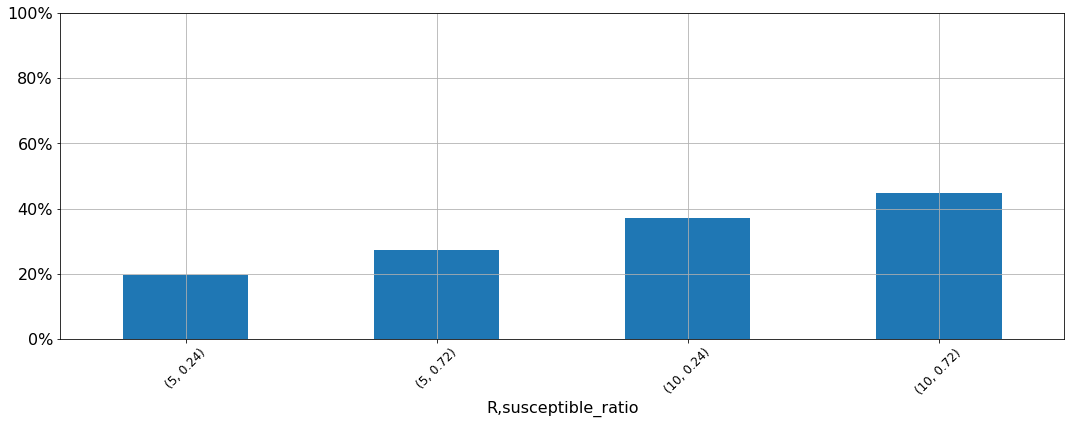

In [580]:
ratios = np.round((summary_table_all_scenarios_passive_groups_CCFR_by_age / summary_table_all_scenarios_MOH), 3)

title='יעילות הגנה על אוכלוסיות סיכון: השוואת תמותה כוללת לתמותה במודל הייחוס במגוון תרחישים'[::-1]
if is_title_off:
    title = None

ax = (100 * ratios).dead.plot.bar(rot=45, title=title)
ax.set_ylim((0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())


In [567]:
ratios.to_csv(path_results.joinpath('passive_groups_to_MOH_R_susceptible_ratio.csv'))
ratios_percent = ((np.round(100 * ratios, 2)).astype(str) + '%').reset_index().iloc[:, ::-1].to_csv(path_results.joinpath('passive_groups_to_MOH_R_susceptible_ratio_percent.csv'))

### taking masks into account
scenarios regarding effectivness of masks in reducing infection probability (masks effectivenss + usage profile):

R in [1.35, 2, 7]. Use only scenarios where R eff > 1

#### reference model
* factor 0.2
* factor 0.55
* factor 0.8

#### focused protection (normal group, sensitive groups):
* 0.9, 0.8
* 0.7, 0.5
* 0.55, 0.2

#### old old old
Usage scenarios:
* no usage
* usage in contact with sensitive populations
* also usage by 30% percent of population
* usage by 60% of population
* usage by people with high interactions number (tellers, messangers)

#### reference model

In [90]:
R_to_check = [1.35, 2, 7]
infection_probability_ratio_to_check = [1, 0.85, 0.55, 0.2]

In [93]:
N_steps = 800
population = age_pyramid.sum()
relative_rates = relative_rates_official
infection_impulse_response = infection_impulse_response
exposed_to_symptomatic_ratio = 0.5
susceptible_ratio = 1

summary_table_many = {}
for R, infection_probability_ratio in itertools.product(R_to_check, infection_probability_ratio_to_check):
    if R * infection_probability_ratio <= 1.05:
        continue
    print(R * infection_probability_ratio)

    dynamics, _ = epidemic_dynamics(*initialize_epidemic_dynamics(symptomatic_new_initial, exposed_to_symptomatic_ratio, population, susceptible_ratio, infection_impulse_response, R, N_steps, transitions_template, relative_rates, infection_probability_ratio=infection_probability_ratio))
    summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())#collect_summary_table
    summary_table_many[(R, infection_probability_ratio)] = summary_table

summary_table_all_scenarios = pd.concat(summary_table_many, names=['R', 'infection_probability_ratio'], axis=1).T
if IS_SAVE_RESULTS:
    summary_table_all_scenarios.to_csv(path_results.joinpath('MOH_model_R_infection_probability_ratio.csv'))

1.35


/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected
  
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong
  """


1.1475
2
1.7
1.1
7
5.95
3.8500000000000005
1.4000000000000001


In [134]:
summary_table_all_scenarios_MOH = pd.read_csv(path_results.joinpath('MOH_model_R_infection_probability_ratio.csv'), index_col=[0, 1])


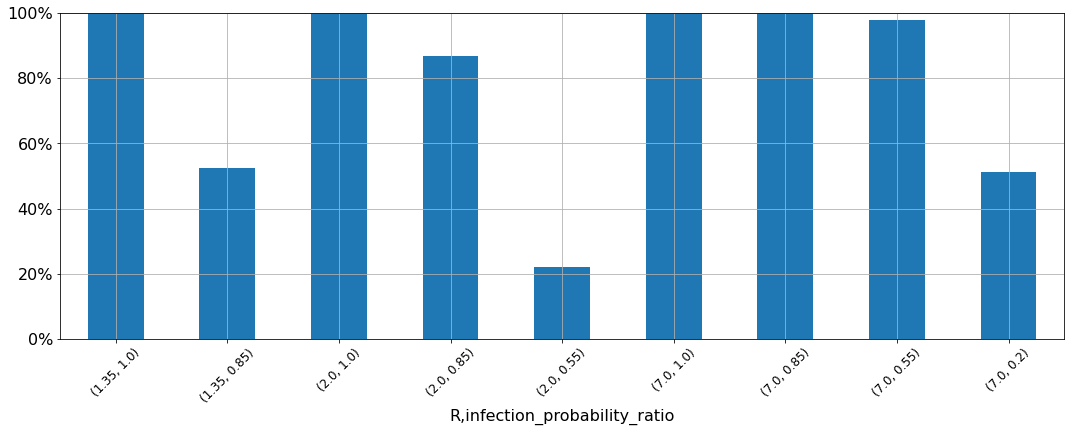

In [135]:
ratios = np.round((summary_table_all_scenarios_MOH / summary_table_all_scenarios_MOH.xs(1, level='infection_probability_ratio')), 3)

#title='יעילות הגנה על אוכלוסיות סיכון: השוואת תמותה כוללת לתמותה במודל הייחוס במגוון תרחישים'[::-1]
if is_title_off:
    title = None

ax = (100 * ratios).dead.plot.bar(rot=45, title=title)
ax.set_ylim((0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [136]:
ratios

exposed  symptomatic  moderate_severe  \
R    infection_probability_ratio                                          
1.35 1.00                           1.000        1.000            1.000   
     0.85                           0.523        0.523            0.523   
2.00 1.00                           1.000        1.000            1.000   
     0.85                           0.867        0.867            0.867   
     0.55                           0.221        0.221            0.221   
7.00 1.00                           1.000        1.000            1.000   
     0.85                           0.998        0.998            0.998   
     0.55                           0.978        0.978            0.978   
     0.20                           0.511        0.511            0.511   

                                  respirated   dead  recover  
R    infection_probability_ratio                              
1.35 1.00                              1.000  1.000    1.000  
     0.85                              0.523  0.523    0.523  
2.00 1.00                              1.000  1.000    1.000  
     0.85                              0.867  0.867    0.867  
     0.55                              0.221  0.221    0.221  
7.00 1.00                              1.000  1.000    1.000  
     0.85                              0.998  0.998    0.998  
     0.55                              0.978  0.978    0.978  
     0.20                              0.511  0.511    0.511

In [101]:
ratios.to_csv(path_results.joinpath('passive_groups_to_MOH_R_susceptible_ratio.csv'))
ratios_percent = ((np.round(100 * ratios, 2)).astype(str) + '%').reset_index().iloc[:, ::-1].to_csv(path_results.joinpath('MOH_model_R_infection_probability_to_no_masks_ratio_percent.csv'))

In [102]:
initialize_epidemic_dynamics_with_passive_groups?

Signature:
initialize_epidemic_dynamics_with_passive_groups(
    N_steps,
    R,
    infection_impulse_response,
    groups_template,
    transitions_template,
    symptomatic_new_initial,
    exposed_to_symptomatic_ratio,
    population_by_group_and_age,
    interactions_ratio_vec,
    susceptible_ratio_vector,
    rates_by_age_group,
    infection_probability_ratio_vec=None,
)
Docstring: <no docstring>
File:      ~/corona/corona_residual_life_expectancy.git/analysis/<ipython-input-74-1b7494bd694b>
Type:      function


#### selective protection model

In [114]:
symptomatic_new_initial = symptomatic_new_initial.copy()
N_steps = 700
#max_confirmed_cases_in_peak_countries = 0.6e-2
#susceptible_ratio_0 = estimate_susceptible_ratio(max_confirmed_cases_in_peak_countries, exposed_to_symptomatic_ratio)

interactions_ratio_vec = pd.Series(index=population_by_group_and_age.columns, data=[0.5, 0.02, 0.1, 1])
population_by_group_and_age = population_by_group_and_age
rates_by_age_group = rates_by_age_group
infection_impulse_response = infection_impulse_response
transitions_template = transitions_template
groups_template = groups.copy()

exposed_to_symptomatic_ratio = 0.5
susceptible_ratio = 1


infection_probability_ratio_vec_to_check = [
    pd.Series(index=population_by_group_and_age.columns, data=[1, 1, 1, 1]),
    pd.Series(index=population_by_group_and_age.columns, data=[0.8, 0.8, 0.8, 0.9]),
    pd.Series(index=population_by_group_and_age.columns, data=[0.5, 0.5, 0.5, 0.7]),
    pd.Series(index=population_by_group_and_age.columns, data=[0.2, 0.2, 0.2, 0.55])    
]


summary_table_many = {}
for R, infection_probability_ratio_vec in itertools.product(R_to_check, infection_probability_ratio_vec_to_check):
    susceptible_ratio_vector = pd.Series(index=population_by_group_and_age.columns, data=[1, 1, susceptible_ratio, susceptible_ratio])

    if R * infection_probability_ratio_vec['normal'] <= 1.05:
        continue
    print(R * infection_probability_ratio_vec['normal'])
    
    init = initialize_epidemic_dynamics_with_passive_groups(
        N_steps, R, infection_impulse_response,
        groups_template, transitions_template,
        symptomatic_new_initial, exposed_to_symptomatic_ratio,
        population_by_group_and_age,
        interactions_ratio_vec,
        susceptible_ratio_vector,
        rates_by_age_group,
        infection_probability_ratio_vec=infection_probability_ratio_vec
        )

    dynamics, _ =  epidemic_dynamics_with_passive_groups(*init)
    summary_table = dynamics.xs(('new',), level=('attr',), axis=1).sum(level='status', axis=1).sum(axis=0)#.sum().sum())
    summary_table_many[(R, tuple(infection_probability_ratio_vec.values))] = summary_table

summary_table_all_scenarios = pd.concat(summary_table_many, names=['R', 'infection_probability_ratio'], axis=1).T
if IS_SAVE_RESULTS:
    summary_table_all_scenarios.to_csv(path_results.joinpath('passive_groups_CCFR_by_age_R_infection_probability_ratio.csv'))




1.35
*********1
*********1
*********1
*********1


/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: bug 1: exposed net delta is like new. but we want to fix this, here exposed~infected
  
/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: bug 2: it seems that symptomatic.net_delta.cumsum() at t~infinite is not 0, but a negative constant. obviously wrong
  """


1.215
*********0.9
*********0.8
*********0.8
*********0.8
2
*********1
*********1
*********1
*********1
1.8
*********0.9
*********0.8
*********0.8
*********0.8
1.4
*********0.7
*********0.5
*********0.5
*********0.5
1.1
*********0.55
*********0.2
*********0.2
*********0.2


/home/ng/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: susceptible exposed time propagation did not converge R2 interactions_ratio1.0 N_steps700 exposed_new step -30 1.9567083181438418 exposed_new step -1 0.9319992226666122


7
*********1
*********1
*********1
*********1
6.3
*********0.9
*********0.8
*********0.8
*********0.8
4.8999999999999995
*********0.7
*********0.5
*********0.5
*********0.5
3.8500000000000005
*********0.55
*********0.2
*********0.2
*********0.2


In [137]:
summary_table_all_scenarios_passive_groups_CCFR_by_age = pd.read_csv(path_results.joinpath('passive_groups_CCFR_by_age_R_infection_probability_ratio.csv'), index_col=[0, 1])


In [119]:
summary_table_all_scenarios_passive_groups_CCFR_by_age.index.to_frame().infection_probability_ratio

R     infection_probability_ratio
1.35  (1, 1, 1, 1)                            (1, 1, 1, 1)
      (0.8, 0.8, 0.8, 0.9)            (0.8, 0.8, 0.8, 0.9)
2.00  (1, 1, 1, 1)                            (1, 1, 1, 1)
      (0.8, 0.8, 0.8, 0.9)            (0.8, 0.8, 0.8, 0.9)
      (0.5, 0.5, 0.5, 0.7)            (0.5, 0.5, 0.5, 0.7)
      (0.2, 0.2, 0.2, 0.55)          (0.2, 0.2, 0.2, 0.55)
7.00  (1, 1, 1, 1)                            (1, 1, 1, 1)
      (0.8, 0.8, 0.8, 0.9)            (0.8, 0.8, 0.8, 0.9)
      (0.5, 0.5, 0.5, 0.7)            (0.5, 0.5, 0.5, 0.7)
      (0.2, 0.2, 0.2, 0.55)          (0.2, 0.2, 0.2, 0.55)
Name: infection_probability_ratio, dtype: object

In [127]:
summary_table_all_scenarios_passive_groups_CCFR_by_age.index.to_frame().infer_objects().dtypes#.index.to_frame().infection_probability_ratio

R                              float64
infection_probability_ratio     object
dtype: object

In [122]:
summary_table_all_scenarios_passive_groups_CCFR_by_age.loc[(1.35, (1,1,1,1)), :]

Empty DataFrame
Columns: [exposed, symptomatic, moderate_severe, respirated, dead, recover]
Index: []

In [130]:
summary_table_all_scenarios_passive_groups_CCFR_by_age.index.to_frame().iloc[0].infection_probability_ratio

'(1, 1, 1, 1)'

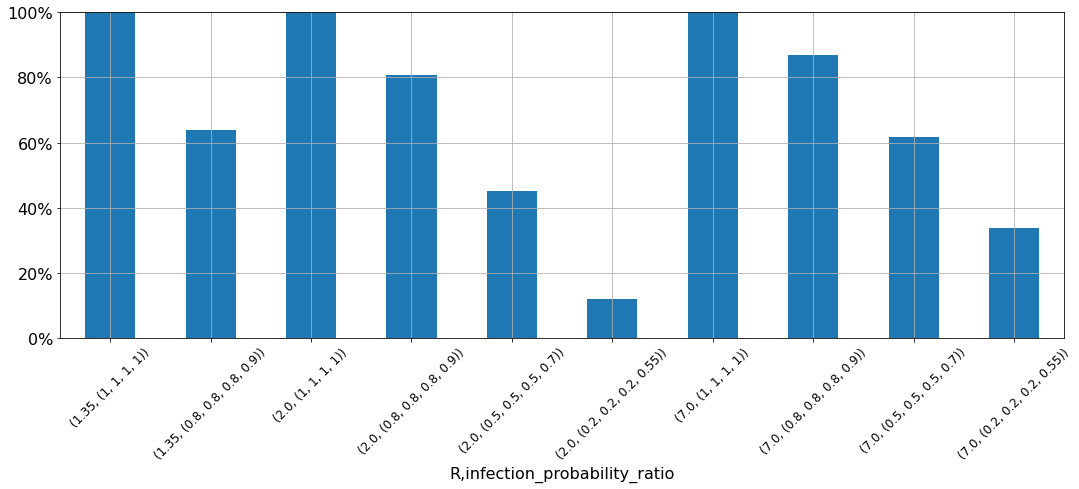

In [138]:
ratios = np.round((summary_table_all_scenarios_passive_groups_CCFR_by_age / summary_table_all_scenarios_passive_groups_CCFR_by_age.xs('(1, 1, 1, 1)', level='infection_probability_ratio')), 3)

#title='יעילות הגנה על אוכלוסיות סיכון: השוואת תמותה כוללת לתמותה במודל הייחוס במגוון תרחישים'[::-1]
if is_title_off:
    title = None

ax = (100 * ratios).dead.plot.bar(rot=45, title=title)
ax.set_ylim((0, 100))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [132]:
ratios.to_csv(path_results.joinpath('passive_groups_to_MOH_R_susceptible_ratio.csv'))
ratios_percent = ((np.round(100 * ratios, 2)).astype(str) + '%').reset_index().iloc[:, ::-1].to_csv(path_results.joinpath('passive_groups_CCFR_by_age_R_infection_probability_to_no_masks_ratio_percent.csv'))

In [139]:
ratios

exposed  symptomatic  moderate_severe  \
R    infection_probability_ratio                                          
1.35 (1, 1, 1, 1)                   1.000        1.000            1.000   
     (0.8, 0.8, 0.8, 0.9)           0.704        0.704            0.639   
2.00 (1, 1, 1, 1)                   1.000        1.000            1.000   
     (0.8, 0.8, 0.8, 0.9)           0.915        0.915            0.806   
     (0.5, 0.5, 0.5, 0.7)           0.634        0.634            0.452   
     (0.2, 0.2, 0.2, 0.55)          0.217        0.217            0.122   
7.00 (1, 1, 1, 1)                   1.000        1.000            1.000   
     (0.8, 0.8, 0.8, 0.9)           0.988        0.988            0.869   
     (0.5, 0.5, 0.5, 0.7)           0.962        0.962            0.617   
     (0.2, 0.2, 0.2, 0.55)          0.924        0.924            0.338   

                                  respirated   dead  recover  
R    infection_probability_ratio                              
1.35 (1, 1, 1, 1)                      1.000  1.000    1.000  
     (0.8, 0.8, 0.8, 0.9)              0.639  0.639    0.705  
2.00 (1, 1, 1, 1)                      1.000  1.000    1.000  
     (0.8, 0.8, 0.8, 0.9)              0.806  0.806    0.915  
     (0.5, 0.5, 0.5, 0.7)              0.452  0.452    0.634  
     (0.2, 0.2, 0.2, 0.55)             0.122  0.122    0.217  
7.00 (1, 1, 1, 1)                      1.000  1.000    1.000  
     (0.8, 0.8, 0.8, 0.9)              0.869  0.869    0.989  
     (0.5, 0.5, 0.5, 0.7)              0.617  0.617    0.964  
     (0.2, 0.2, 0.2, 0.55)             0.338  0.338    0.926

## Fitting to hospitalized (=moderate severe)

## comparing to official predictions